# Micro & Macro Analysis: Model Comparison

This notebook visualizes and compares the micro and macro evaluation results for all datasets (eudract, allergen, flight). Duplicate code is removed and plotting is handled by reusable functions. Each dataset retains its own graphs and results.

In [1]:
import sys
import os

# Add the parent directory to the path so the package is importable
sys.path.append(os.path.abspath("../.."))

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from typing import Dict
from matplotlib.patches import Patch
from tabulate import tabulate  # Added for table printing
from llm_data_quality_assistant.evaluation import calculate_macro_stats

# Custom color palette as requested
# Color palette for all models
COLORS = [
    "#FF6F61",
    "#6B5B95",
    "#88B04B",
    "#F7CAC9",
    "#92A8D1",
    "#955251",
    "#B565A7",
    "#009B77",
]


METRICS = ["accuracy", "f1_score", "precision", "recall"]

FONT_SCALE = 1.3  # Variable for font scale

def load_model_data(base_path: str, files: Dict[str, str]) -> Dict[str, dict]:
    model_data = {}
    for model, file_name in files.items():
        with open(os.path.join(base_path, file_name), 'r') as f:
            model_data[model] = json.load(f)
    return model_data

def set_l_shaped_border(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

def plot_micro_analysis(model_data: Dict[str, dict], highlight: bool = True, title: str = ""):
    sns.set_context('notebook', font_scale=FONT_SCALE)
    models = list(model_data.keys())
    data = []
    for model in models:
        for metric in METRICS:
            data.append({
                'Model': model,
                'Metric': metric,
                'Score': model_data[model][metric]
            })
    df = pd.DataFrame(data)
    print(tabulate(df, headers='keys', tablefmt='github', floatfmt='.3f'))
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df,
        x='Metric',
        y='Score',
        hue='Model',
        palette=COLORS[:len(models)],
        edgecolor=None
    )
    set_l_shaped_border(ax)
    for c in ax.containers:
        ax.bar_label(c, fmt='%.3f', label_type='edge', rotation=45, padding=4)
    y_max = df['Score'].max()
    ax.set_ylim(0, y_max + 0.5)
    ax.set_ylabel("Score")
    if title is not None and title != "":
        ax.set_title(title)
    if highlight:
        for metric in METRICS:
            metric_df = df[df['Metric'] == metric]
            max_score = metric_df['Score'].max()
            for i, row in metric_df.iterrows():
                if row['Score'] == max_score:
                    idx = list(df[(df['Metric'] == metric) & (df['Score'] == max_score)].index)[0]
                    rect = ax.patches[idx]
                    rect.set_edgecolor('#FFFF00')
                    rect.set_linewidth(3)
    plt.tight_layout(pad=2.0)
    plt.show()


def plot_macro_analysis(model_data: Dict[str, dict], highlight: bool = True, title: str = ""):
    model_data = {model: calculate_macro_stats(data) for model, data in model_data.items()}
    plot_micro_analysis(model_data=model_data, highlight=highlight, title=title)

def plot_column_analysis(model_data: Dict[str, dict], show_annotations: bool = False, highlight: bool = True, title: str = ""):
    sns.set_context('notebook', font_scale=FONT_SCALE)
    column_names = list(model_data.values())[0]["column_names"]
    models = list(model_data.keys())
    metrics_to_plot = ['precision', 'recall']
    data = []
    for model in models:
        for col in model_data[model]["stats"]:
            for metric in metrics_to_plot:
                data.append({
                    'Model': model,
                    'Column': col['column_name'],
                    'Metric': metric,
                    'Score': col[metric]
                })
    df = pd.DataFrame(data)
    print(tabulate(df, headers='keys', tablefmt='github', floatfmt='.3f'))
    fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)
    # fig.suptitle(f"...", fontsize=22, y=1.02)
    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        sub_df = df[df['Metric'] == metric]
        bar = sns.barplot(
            data=sub_df,
            x='Column',
            y='Score',
            hue='Model',
            palette=COLORS[:len(models)],
            ax=ax,
            edgecolor=None
        )
        set_l_shaped_border(ax)
        if show_annotations:
            for c in ax.containers:
                ax.bar_label(c, fmt='%.2f', label_type='edge', rotation=45, padding=4)
        y_max = sub_df['Score'].max()
        ax.set_ylim(0, y_max + 0.5)
        ax.set_ylabel(metric, fontsize=18)
        ax.tick_params(axis='y', labelsize=14)
        ax.legend()
        if title is not None and title != "":
            ax.set_title(title)
    axes[-1].set_xticklabels(column_names, rotation=90, ha='right', fontsize=14)
    plt.tight_layout(rect=(0, 0, 1, 0.90), pad=2.0)
    plt.show()

def plot_difference_vs_parker(model_data: Dict[str, dict], title: str = ""):
    sns.set_context('notebook', font_scale=FONT_SCALE)
    baseline = "Parker"
    if baseline not in model_data:
        print(f"Baseline '{baseline}' not found in model_data.")
        return
    models = [m for m in model_data.keys() if m != baseline]
    data = []
    for model in models:
        for metric in METRICS:
            diff = model_data[model][metric] - model_data[baseline][metric]
            data.append({
                'Model': model,
                'Metric': metric,
                'Difference': diff
            })
    df = pd.DataFrame(data)
    print(tabulate(df, headers='keys', tablefmt='github', floatfmt='.3f'))
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df,
        x='Metric',
        y='Difference',
        hue='Model',
        palette=COLORS[:len(models)],
        edgecolor=None
    )
    set_l_shaped_border(ax)
    for c in ax.containers:
        ax.bar_label(c, fmt='%+.3f', label_type='edge', rotation=45, padding=4)
    y_min = df['Difference'].min()
    y_max = df['Difference'].max()
    ax.set_ylim(y_min - 0.1, y_max + 0.1)
    ax.axhline(0, color='black', linewidth=1, linestyle='--')
    ax.set_ylabel("Difference vs Parker")
    if title is not None and title != "":
        ax.set_title(title)
    plt.tight_layout(pad=2.0)
    plt.show()

def plot_column_difference_vs_parker(model_data: Dict[str, dict], title: str = ""):
    sns.set_context('notebook', font_scale=FONT_SCALE)
    baseline = "Parker"
    if baseline not in model_data:
        print(f"Baseline '{baseline}' not found in model_data.")
        return
    column_names = list(model_data[baseline]["column_names"])
    models = [m for m in model_data.keys() if m != baseline]
    metrics_to_plot = ['precision', 'recall']
    data = []
    for model in models:
        for col in model_data[model]["stats"]:
            col_name = col['column_name']
            base_col = next((b for b in model_data[baseline]["stats"] if b['column_name'] == col_name), None)
            if base_col:
                for metric in metrics_to_plot:
                    diff = col[metric] - base_col[metric]
                    data.append({
                        'Model': model,
                        'Column': col_name,
                        'Metric': metric,
                        'Difference': diff
                    })
    df = pd.DataFrame(data)
    print(tabulate(df, headers='keys', tablefmt='github', floatfmt='.3f'))
    fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)
    # fig.suptitle(f"...", fontsize=22, y=1.02)
    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        sub_df = df[df['Metric'] == metric]
        sns.barplot(
            data=sub_df,
            x='Column',
            y='Difference',
            hue='Model',
            palette=COLORS[:len(models)],
            ax=ax,
            edgecolor=None
        )
        set_l_shaped_border(ax)
        for c in ax.containers:
            ax.bar_label(c, fmt='%+.2f', label_type='edge', rotation=45, padding=4)
        y_min = sub_df['Difference'].min()
        y_max = sub_df['Difference'].max()
        ax.set_ylim(y_min - 0.1, y_max + 0.1)
        ax.axhline(0, color='black', linewidth=1, linestyle='--')
        ax.set_ylabel(f"{metric} Difference vs Parker", fontsize=18)
        ax.tick_params(axis='y', labelsize=14)
        ax.legend()
        if title is not None and title != "":
            ax.set_title(title)
    axes[-1].set_xticklabels(column_names, rotation=90, ha='right', fontsize=14)
    plt.tight_layout(rect=(0, 0, 1, 0.90), pad=2.0)
    plt.show()

def plot_f1_score_only(model_data: Dict[str, dict], title: str = ""):
    sns.set_context('notebook', font_scale=FONT_SCALE)
    models = list(model_data.keys())
    data = []
    for model in models:
        data.append({'Model': model, 'F1 Score': model_data[model]["f1_score"]})
    df = pd.DataFrame(data)
    print(tabulate(df, headers='keys', tablefmt='github', floatfmt='.3f'))
    min_f1 = df['F1 Score'].min()
    max_f1 = df['F1 Score'].max()
    margin = max(0.01, (max_f1 - min_f1) * 0.2)
    y_min = max(0, min_f1 - margin)
    y_max = min(1, max_f1 + margin)
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(
        data=df,
        x='Model',
        y='F1 Score',
        palette=COLORS[:len(models)],
        edgecolor=None
    )
    set_l_shaped_border(ax)
    for c in ax.containers:
        ax.bar_label(c, fmt='%.3f', label_type='edge', padding=4)
    ax.set_ylabel("F1 Score")
    if title is not None and title != "":
        ax.set_title(title)
    ax.set_ylim(y_min, y_max)
    plt.xticks(rotation=20)
    plt.tight_layout(pad=2.0)
    plt.show()

# EudraCT Dataset

EudractCT - Micro Analysis: Model Comparison by Metric
|    | Model                                   | Metric    |   Score |
|----|-----------------------------------------|-----------|---------|
|  0 | Parker                                  | accuracy  |   0.944 |
|  1 | Parker                                  | f1_score  |   0.655 |
|  2 | Parker                                  | precision |   0.920 |
|  3 | Parker                                  | recall    |   0.509 |
|  4 | Gemini 2.0 Flash Lite (0 rows context)  | accuracy  |   0.932 |
|  5 | Gemini 2.0 Flash Lite (0 rows context)  | f1_score  |   0.549 |
|  6 | Gemini 2.0 Flash Lite (0 rows context)  | precision |   0.910 |
|  7 | Gemini 2.0 Flash Lite (0 rows context)  | recall    |   0.393 |
|  8 | Gemini 2.0 Flash Lite (50 rows context) | accuracy  |   0.944 |
|  9 | Gemini 2.0 Flash Lite (50 rows context) | f1_score  |   0.655 |
| 10 | Gemini 2.0 Flash Lite (50 rows context) | precision |   0.917 |
| 11 | Gemini 2.0 Flas

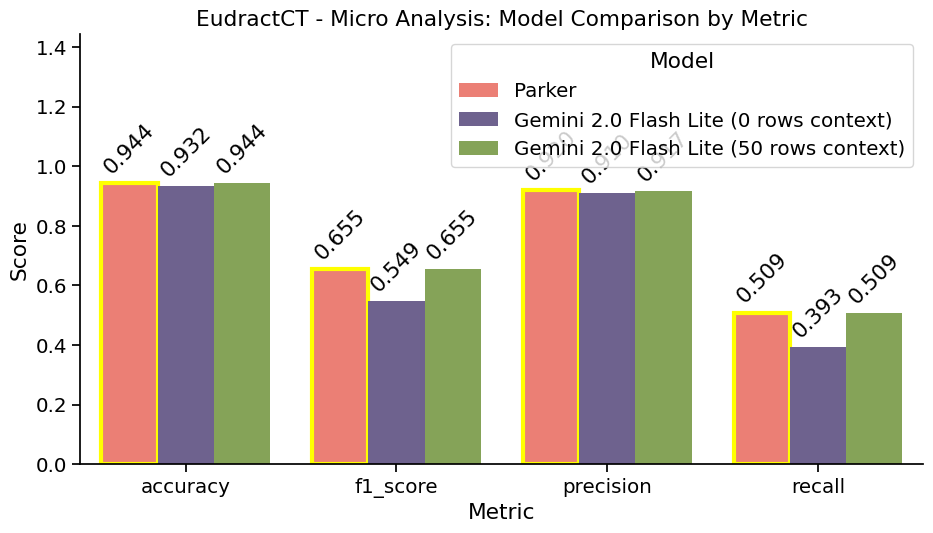

EudractCT - Macro Analysis: Model Comparison by Metric
|    | Model                                   | Metric    |   Score |
|----|-----------------------------------------|-----------|---------|
|  0 | Parker                                  | accuracy  |   0.944 |
|  1 | Parker                                  | f1_score  |   0.562 |
|  2 | Parker                                  | precision |   0.786 |
|  3 | Parker                                  | recall    |   0.472 |
|  4 | Gemini 2.0 Flash Lite (0 rows context)  | accuracy  |   0.932 |
|  5 | Gemini 2.0 Flash Lite (0 rows context)  | f1_score  |   0.535 |
|  6 | Gemini 2.0 Flash Lite (0 rows context)  | precision |   0.766 |
|  7 | Gemini 2.0 Flash Lite (0 rows context)  | recall    |   0.437 |
|  8 | Gemini 2.0 Flash Lite (50 rows context) | accuracy  |   0.944 |
|  9 | Gemini 2.0 Flash Lite (50 rows context) | f1_score  |   0.561 |
| 10 | Gemini 2.0 Flash Lite (50 rows context) | precision |   0.778 |
| 11 | Gemini 2.0 Flas

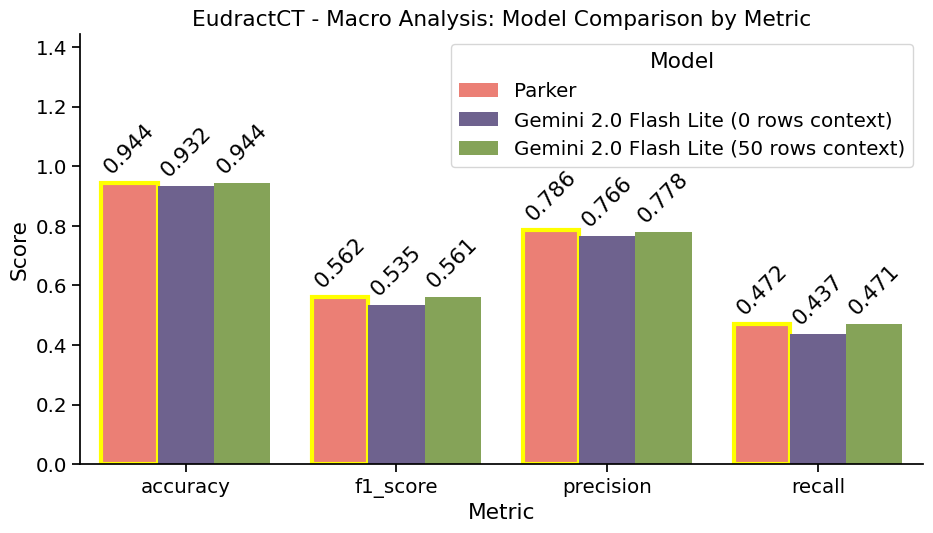

EudractCT - Column Analysis: Model Comparison by Metric
|    | Model                                   | Column         | Metric    |   Score |
|----|-----------------------------------------|----------------|-----------|---------|
|  0 | Parker                                  | eudract_number | precision |   0.000 |
|  1 | Parker                                  | eudract_number | recall    |   0.000 |
|  2 | Parker                                  | arms           | precision |   0.991 |
|  3 | Parker                                  | arms           | recall    |   0.717 |
|  4 | Parker                                  | controlled     | precision |   0.816 |
|  5 | Parker                                  | controlled     | recall    |   0.203 |
|  6 | Parker                                  | crossover      | precision |   0.914 |
|  7 | Parker                                  | crossover      | recall    |   0.517 |
|  8 | Parker                                  | double_blind   

/tmp/ipykernel_64683/2777122064.py:139: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(column_names, rotation=90, ha='right', fontsize=14)


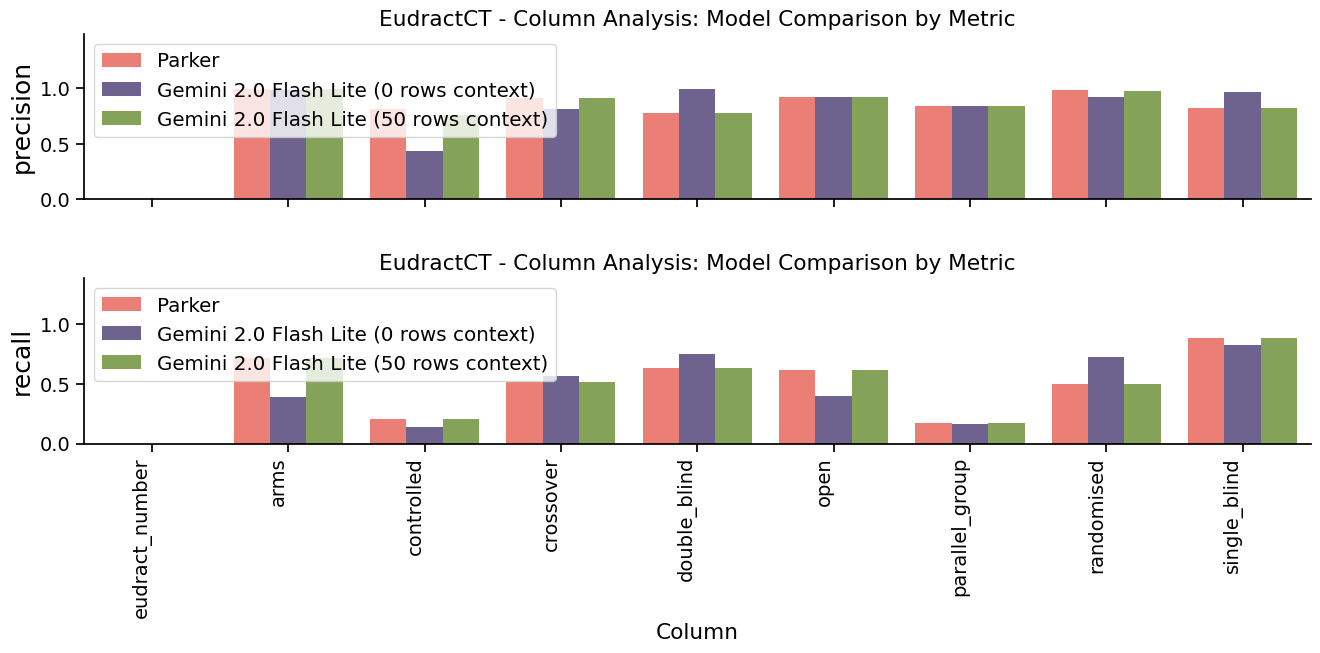

EudractCT - Difference vs Parker (Micro)
|    | Model                                   | Metric    |   Difference |
|----|-----------------------------------------|-----------|--------------|
|  0 | Gemini 2.0 Flash Lite (0 rows context)  | accuracy  |       -0.012 |
|  1 | Gemini 2.0 Flash Lite (0 rows context)  | f1_score  |       -0.106 |
|  2 | Gemini 2.0 Flash Lite (0 rows context)  | precision |       -0.009 |
|  3 | Gemini 2.0 Flash Lite (0 rows context)  | recall    |       -0.116 |
|  4 | Gemini 2.0 Flash Lite (50 rows context) | accuracy  |       -0.000 |
|  5 | Gemini 2.0 Flash Lite (50 rows context) | f1_score  |       -0.001 |
|  6 | Gemini 2.0 Flash Lite (50 rows context) | precision |       -0.002 |
|  7 | Gemini 2.0 Flash Lite (50 rows context) | recall    |       -0.000 |


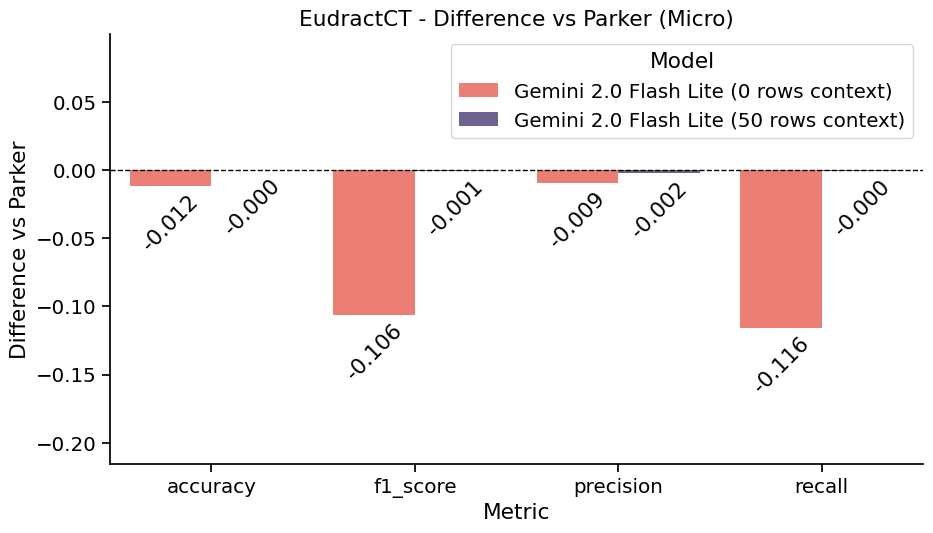

EudractCT - Difference vs Parker (Column)
|    | Model                                   | Column         | Metric    |   Difference |
|----|-----------------------------------------|----------------|-----------|--------------|
|  0 | Gemini 2.0 Flash Lite (0 rows context)  | eudract_number | precision |        0.000 |
|  1 | Gemini 2.0 Flash Lite (0 rows context)  | eudract_number | recall    |        0.000 |
|  2 | Gemini 2.0 Flash Lite (0 rows context)  | arms           | precision |       -0.007 |
|  3 | Gemini 2.0 Flash Lite (0 rows context)  | arms           | recall    |       -0.332 |
|  4 | Gemini 2.0 Flash Lite (0 rows context)  | controlled     | precision |       -0.378 |
|  5 | Gemini 2.0 Flash Lite (0 rows context)  | controlled     | recall    |       -0.065 |
|  6 | Gemini 2.0 Flash Lite (0 rows context)  | crossover      | precision |       -0.099 |
|  7 | Gemini 2.0 Flash Lite (0 rows context)  | crossover      | recall    |        0.045 |
|  8 | Gemini 2.0 Flash Lite

/tmp/ipykernel_64683/2777122064.py:234: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(column_names, rotation=90, ha='right', fontsize=14)


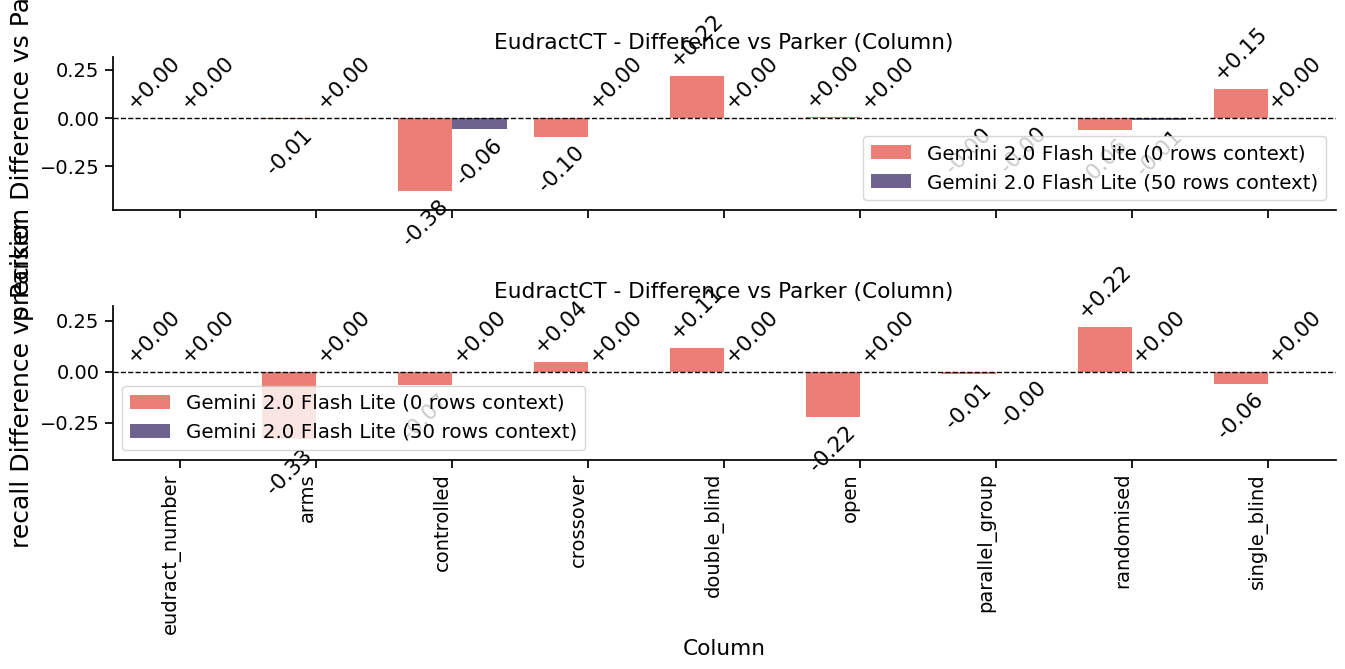

In [2]:
# EudraCT paths and files
base_path = os.path.join('.', 'eudract')
micro_files = {
    "Parker": "parker_results_micro.json",
    "Gemini 2.0 Flash Lite (0 rows context)": "gemini_2_0_flash_lite_0_rows_context_results_micro.json",
    "Gemini 2.0 Flash Lite (50 rows context)": "gemini_2_0_flash_lite_50_rows_context_simple_approach_results_micro.json",
}
macro_files = {
    "Parker": "parker_results_macro.json",
    "Gemini 2.0 Flash Lite (0 rows context)": "gemini_2_0_flash_lite_0_rows_context_results_macro.json",
    "Gemini 2.0 Flash Lite (50 rows context)": "gemini_2_0_flash_lite_50_rows_context_simple_approach_results_macro.json",
}
# Micro
model_data = load_model_data(base_path, micro_files)
title = "EudractCT - Micro Analysis: Model Comparison by Metric"
print(title)
plot_micro_analysis(model_data, title=title)

# Macro
model_data = load_model_data(base_path, macro_files)
title = "EudractCT - Macro Analysis: Model Comparison by Metric"
print(title)
plot_macro_analysis(model_data, title=title)

title = "EudractCT - Column Analysis: Model Comparison by Metric"
print(title)
plot_column_analysis(model_data, title=title)

# Difference vs Parker (Micro)
title = "EudractCT - Difference vs Parker (Micro)"
print(title)
plot_difference_vs_parker(load_model_data(base_path, micro_files), title=title)

# Difference vs Parker (Macro)
title = "EudractCT - Difference vs Parker (Column)"
print(title)
plot_column_difference_vs_parker(load_model_data(base_path, macro_files), title=title)

|    | Model                                   |   F1 Score |
|----|-----------------------------------------|------------|
|  0 | Parker                                  |      0.655 |
|  1 | Gemini 2.0 Flash Lite (0 rows context)  |      0.549 |
|  2 | Gemini 2.0 Flash Lite (50 rows context) |      0.655 |


/tmp/ipykernel_64683/2777122064.py:252: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


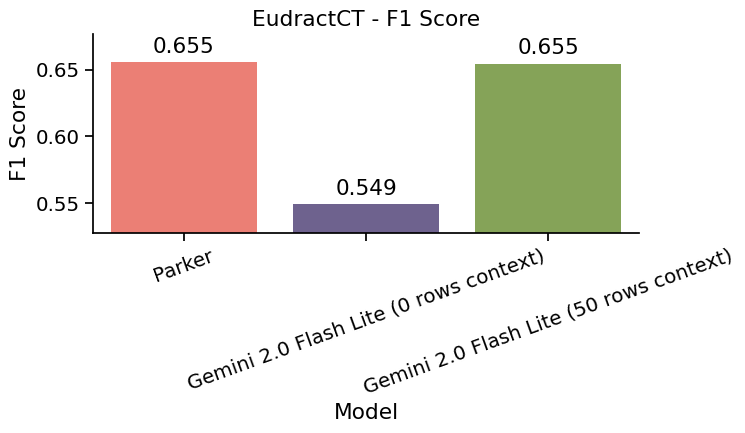

In [3]:
# F1 Score Only - EudraCT
model_data = load_model_data(base_path, micro_files)
title = "EudractCT - F1 Score"
plot_f1_score_only(model_data, title=title)


# EudraCT (Different Options)

This section compares the different EudraCT repair options (Option 1, Option 2, Option 3) and Parker baseline.

EudraCT (Options) - Micro Analysis: Model Comparison by Metric
|    | Model                                                     | Metric    |   Score |
|----|-----------------------------------------------------------|-----------|---------|
|  0 | Parker                                                    | accuracy  |   0.944 |
|  1 | Parker                                                    | f1_score  |   0.655 |
|  2 | Parker                                                    | precision |   0.920 |
|  3 | Parker                                                    | recall    |   0.509 |
|  4 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | accuracy  |   0.944 |
|  5 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | f1_score  |   0.655 |
|  6 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | precision |   0.917 |
|  7 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | recall    |   0.509 |
|  8 | Gemini 2.0 Flash Lite (50 rows context) 

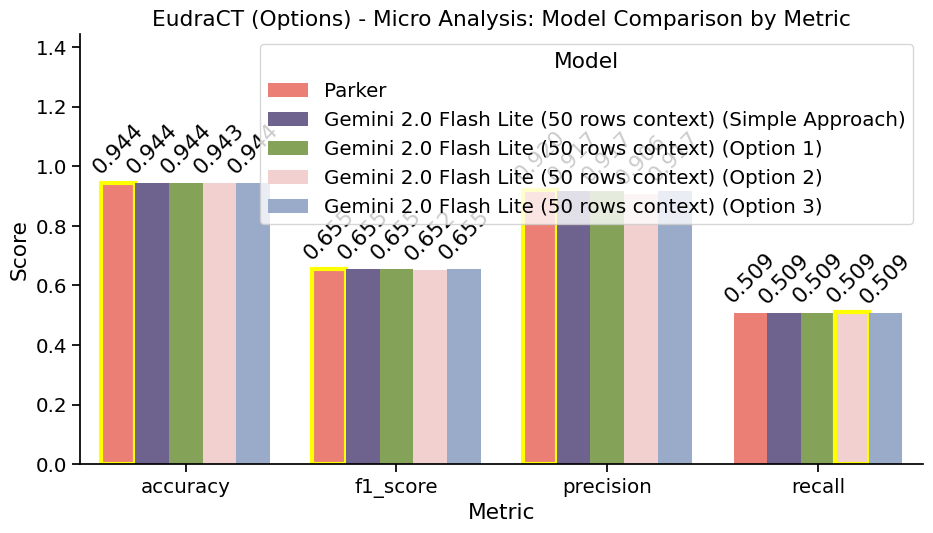

EudraCT (Options) - Macro Analysis: Model Comparison by Metric
|    | Model                                                     | Metric    |   Score |
|----|-----------------------------------------------------------|-----------|---------|
|  0 | Parker                                                    | accuracy  |   0.944 |
|  1 | Parker                                                    | f1_score  |   0.562 |
|  2 | Parker                                                    | precision |   0.786 |
|  3 | Parker                                                    | recall    |   0.472 |
|  4 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | accuracy  |   0.944 |
|  5 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | f1_score  |   0.561 |
|  6 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | precision |   0.778 |
|  7 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | recall    |   0.471 |
|  8 | Gemini 2.0 Flash Lite (50 rows context) 

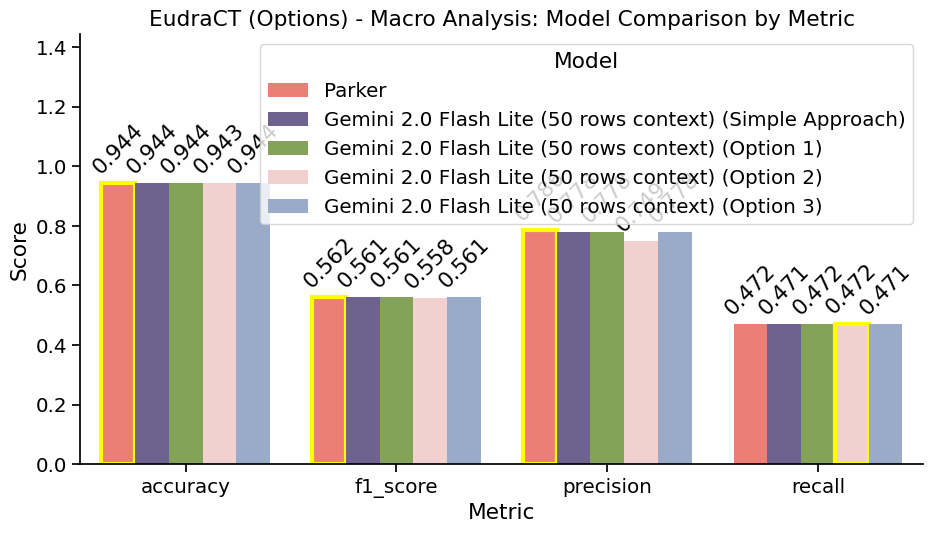

EudraCT (Options) - Column Analysis: Model Comparison by Metric
|    | Model                                                     | Column         | Metric    |   Score |
|----|-----------------------------------------------------------|----------------|-----------|---------|
|  0 | Parker                                                    | eudract_number | precision |   0.000 |
|  1 | Parker                                                    | eudract_number | recall    |   0.000 |
|  2 | Parker                                                    | arms           | precision |   0.991 |
|  3 | Parker                                                    | arms           | recall    |   0.717 |
|  4 | Parker                                                    | controlled     | precision |   0.816 |
|  5 | Parker                                                    | controlled     | recall    |   0.203 |
|  6 | Parker                                                    | crossover      | prec

/tmp/ipykernel_64683/2777122064.py:139: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(column_names, rotation=90, ha='right', fontsize=14)


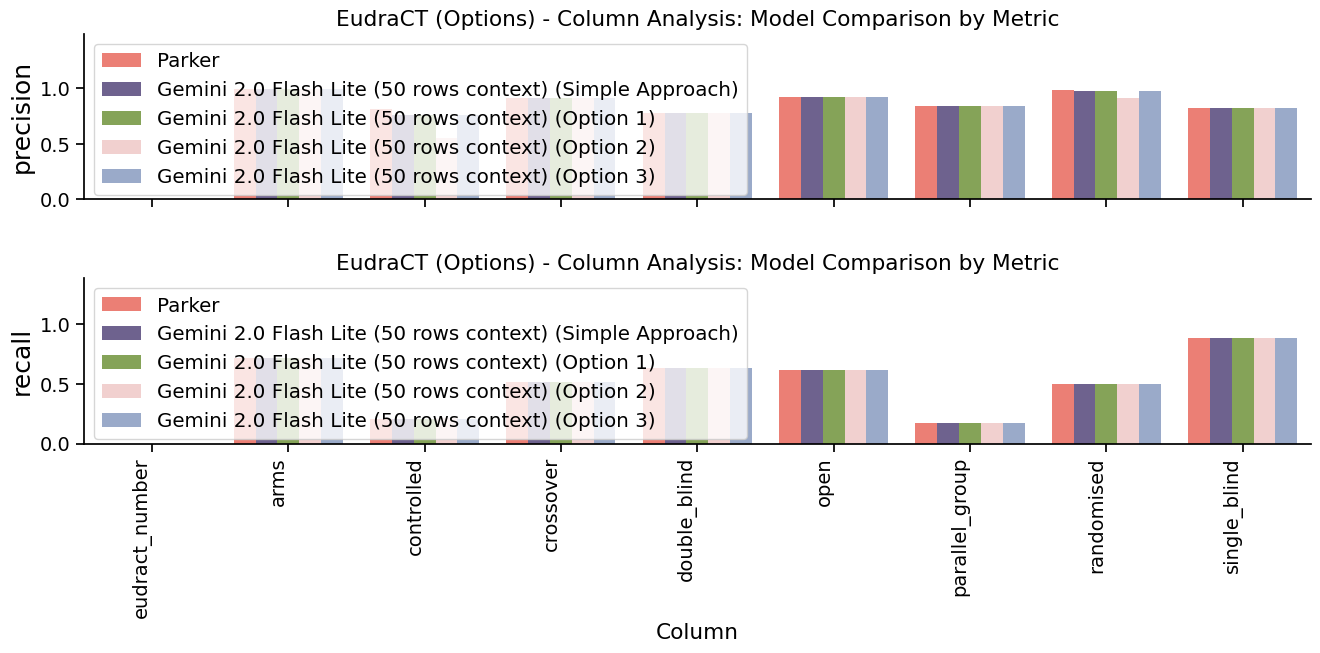

EudraCT (Options) - Difference vs Parker (Micro)
|    | Model                                                     | Metric    |   Difference |
|----|-----------------------------------------------------------|-----------|--------------|
|  0 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | accuracy  |       -0.000 |
|  1 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | f1_score  |       -0.001 |
|  2 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | precision |       -0.002 |
|  3 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | recall    |       -0.000 |
|  4 | Gemini 2.0 Flash Lite (50 rows context) (Option 1)        | accuracy  |       -0.000 |
|  5 | Gemini 2.0 Flash Lite (50 rows context) (Option 1)        | f1_score  |       -0.001 |
|  6 | Gemini 2.0 Flash Lite (50 rows context) (Option 1)        | precision |       -0.002 |
|  7 | Gemini 2.0 Flash Lite (50 rows context) (Option 1)        | recall    |        0.000 |
|  8 | Gemi

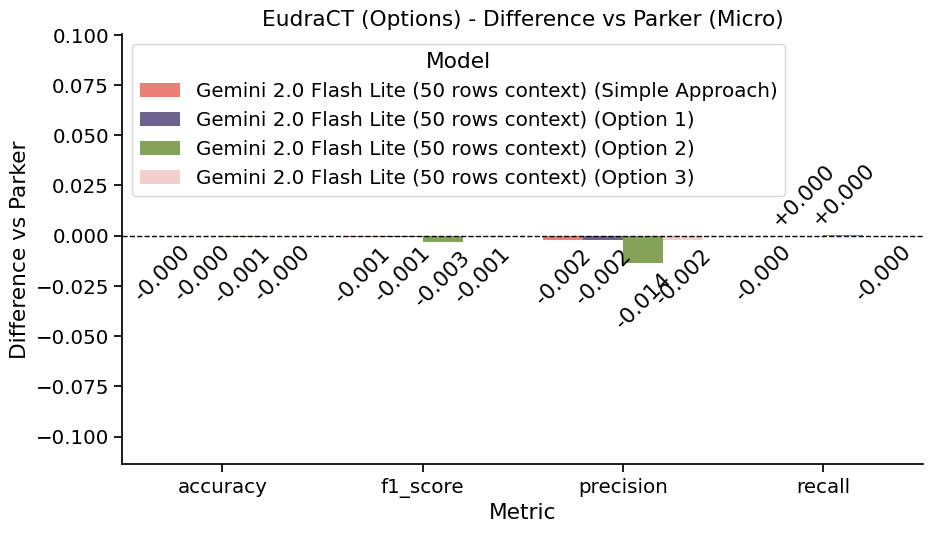

EudraCT (Options) - Difference vs Parker (Column)
|    | Model                                                     | Column         | Metric    |   Difference |
|----|-----------------------------------------------------------|----------------|-----------|--------------|
|  0 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | eudract_number | precision |        0.000 |
|  1 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | eudract_number | recall    |        0.000 |
|  2 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | arms           | precision |        0.000 |
|  3 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | arms           | recall    |        0.000 |
|  4 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | controlled     | precision |       -0.060 |
|  5 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | controlled     | recall    |        0.000 |
|  6 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approac

/tmp/ipykernel_64683/2777122064.py:234: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(column_names, rotation=90, ha='right', fontsize=14)


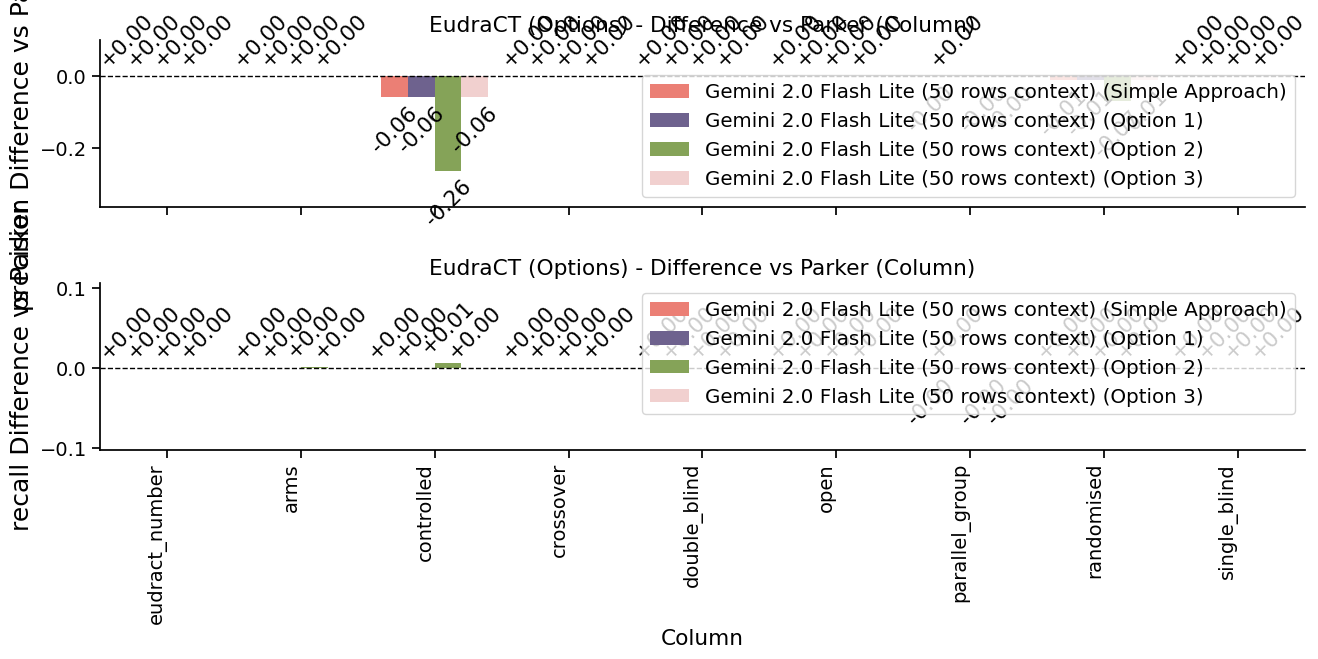

In [4]:
# EudraCT (Different Options) paths and files
base_path = os.path.join('.', 'eudract')
micro_files = {
    "Parker": "parker_results_micro.json",
    "Gemini 2.0 Flash Lite (50 rows context) (Simple Approach)": "gemini_2_0_flash_lite_50_rows_context_simple_approach_results_micro.json",
    "Gemini 2.0 Flash Lite (50 rows context) (Option 1)": "gemini_2_0_flash_lite_50_rows_context_option_1_results_micro.json",
    "Gemini 2.0 Flash Lite (50 rows context) (Option 2)": "gemini_2_0_flash_lite_50_rows_context_parker_postprocessing_option_2_results_micro.json",
    "Gemini 2.0 Flash Lite (50 rows context) (Option 3)": "gemini_2_0_flash_lite_50_rows_context_option_3_results_micro.json",
}
macro_files = {
    "Parker": "parker_results_macro.json",
    "Gemini 2.0 Flash Lite (50 rows context) (Simple Approach)": "gemini_2_0_flash_lite_50_rows_context_simple_approach_results_macro.json",
    "Gemini 2.0 Flash Lite (50 rows context) (Option 1)": "gemini_2_0_flash_lite_50_rows_context_option_1_results_macro.json",
    "Gemini 2.0 Flash Lite (50 rows context) (Option 2)": "gemini_2_0_flash_lite_50_rows_context_parker_postprocessing_option_2_results_macro.json",
    "Gemini 2.0 Flash Lite (50 rows context) (Option 3)": "gemini_2_0_flash_lite_50_rows_context_option_3_results_macro.json",
}
# Micro
model_data = load_model_data(base_path, micro_files)
title = "EudraCT (Options) - Micro Analysis: Model Comparison by Metric"
print(title)
plot_micro_analysis(model_data, title=title)

# Macro
model_data = load_model_data(base_path, macro_files)
title = "EudraCT (Options) - Macro Analysis: Model Comparison by Metric"
print(title)
plot_macro_analysis(model_data, title=title)

title = "EudraCT (Options) - Column Analysis: Model Comparison by Metric"
print(title)
plot_column_analysis(model_data, title=title)

# Difference vs Parker (Micro)
title = "EudraCT (Options) - Difference vs Parker (Micro)"
print(title)
plot_difference_vs_parker(load_model_data(base_path, micro_files), title=title)

# Difference vs Parker (Macro)
title = "EudraCT (Options) - Difference vs Parker (Column)"
print(title)
plot_column_difference_vs_parker(load_model_data(base_path, macro_files), title=title)

EudraCT (Options) - F1 Score
|    | Model                                                     |   F1 Score |
|----|-----------------------------------------------------------|------------|
|  0 | Parker                                                    |      0.655 |
|  1 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) |      0.655 |
|  2 | Gemini 2.0 Flash Lite (50 rows context) (Option 1)        |      0.655 |
|  3 | Gemini 2.0 Flash Lite (50 rows context) (Option 2)        |      0.652 |
|  4 | Gemini 2.0 Flash Lite (50 rows context) (Option 3)        |      0.655 |


/tmp/ipykernel_64683/2777122064.py:252: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


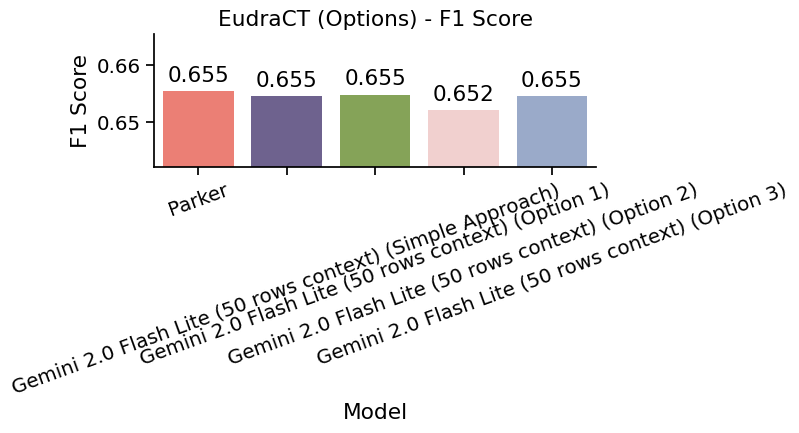

In [5]:
# F1 Score Only - EudraCT (Options)
model_data = load_model_data(base_path, micro_files)
title = "EudraCT (Options) - F1 Score"
print(title)
plot_f1_score_only(model_data, title=title)


# Allergen Dataset

Allergen - Micro Analysis: Model Comparison by Metric
|    | Model                                    | Metric    |   Score |
|----|------------------------------------------|-----------|---------|
|  0 | Parker                                   | accuracy  |   0.938 |
|  1 | Parker                                   | f1_score  |   0.438 |
|  2 | Parker                                   | precision |   0.764 |
|  3 | Parker                                   | recall    |   0.307 |
|  4 | Gemini 2.0 Flash Lite (50 rows context)  | accuracy  |   0.939 |
|  5 | Gemini 2.0 Flash Lite (50 rows context)  | f1_score  |   0.448 |
|  6 | Gemini 2.0 Flash Lite (50 rows context)  | precision |   0.789 |
|  7 | Gemini 2.0 Flash Lite (50 rows context)  | recall    |   0.313 |
|  8 | Gemini 2.0 Flash Lite (200 rows context) | accuracy  |   0.939 |
|  9 | Gemini 2.0 Flash Lite (200 rows context) | f1_score  |   0.448 |
| 10 | Gemini 2.0 Flash Lite (200 rows context) | precision |   0.774 |
| 11 | Gem

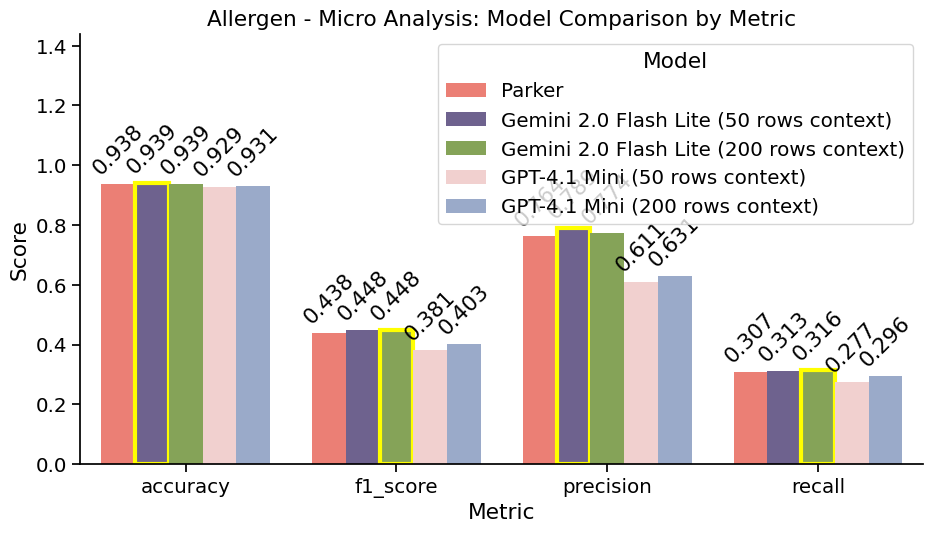

Allergen - Macro Analysis: Model Comparison by Metric
|    | Model                                    | Metric    |   Score |
|----|------------------------------------------|-----------|---------|
|  0 | Parker                                   | accuracy  |   0.938 |
|  1 | Parker                                   | f1_score  |   0.281 |
|  2 | Parker                                   | precision |   0.424 |
|  3 | Parker                                   | recall    |   0.237 |
|  4 | Gemini 2.0 Flash Lite (50 rows context)  | accuracy  |   0.939 |
|  5 | Gemini 2.0 Flash Lite (50 rows context)  | f1_score  |   0.288 |
|  6 | Gemini 2.0 Flash Lite (50 rows context)  | precision |   0.432 |
|  7 | Gemini 2.0 Flash Lite (50 rows context)  | recall    |   0.242 |
|  8 | Gemini 2.0 Flash Lite (200 rows context) | accuracy  |   0.939 |
|  9 | Gemini 2.0 Flash Lite (200 rows context) | f1_score  |   0.286 |
| 10 | Gemini 2.0 Flash Lite (200 rows context) | precision |   0.402 |
| 11 | Gem

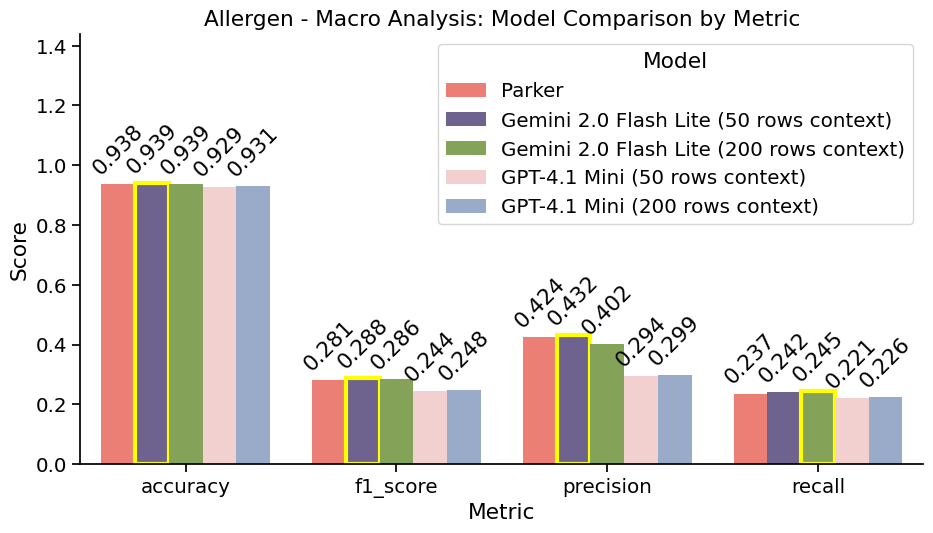

Allergen - Column Analysis: Model Comparison by Metric
|     | Model                                    | Column         | Metric    |   Score |
|-----|------------------------------------------|----------------|-----------|---------|
|   0 | Parker                                   | code           | precision |   0.000 |
|   1 | Parker                                   | code           | recall    |   0.000 |
|   2 | Parker                                   | nuts           | precision |   0.852 |
|   3 | Parker                                   | nuts           | recall    |   0.561 |
|   4 | Parker                                   | almondnuts     | precision |   1.000 |
|   5 | Parker                                   | almondnuts     | recall    |   0.012 |
|   6 | Parker                                   | brazil_nuts    | precision |   0.000 |
|   7 | Parker                                   | brazil_nuts    | recall    |   0.000 |
|   8 | Parker                               

/tmp/ipykernel_64683/2777122064.py:139: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(column_names, rotation=90, ha='right', fontsize=14)


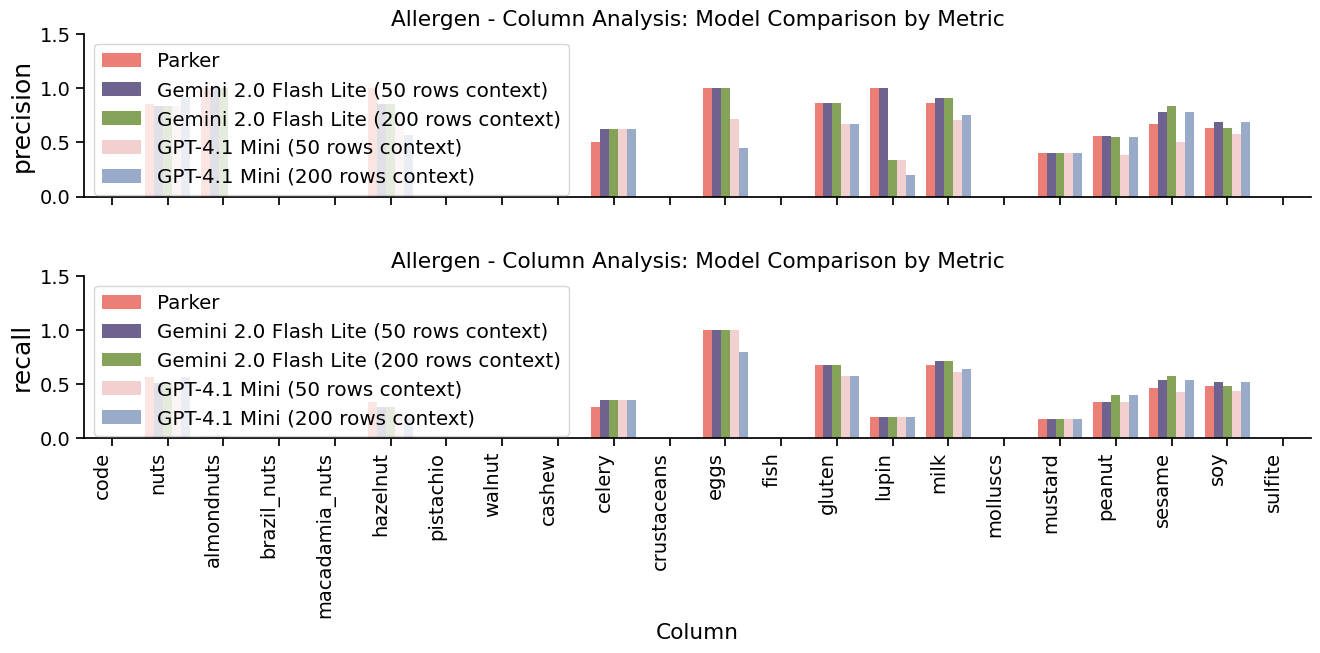

Allergen - Difference vs Parker (Micro)
|    | Model                                    | Metric    |   Difference |
|----|------------------------------------------|-----------|--------------|
|  0 | Gemini 2.0 Flash Lite (50 rows context)  | accuracy  |        0.001 |
|  1 | Gemini 2.0 Flash Lite (50 rows context)  | f1_score  |        0.010 |
|  2 | Gemini 2.0 Flash Lite (50 rows context)  | precision |        0.025 |
|  3 | Gemini 2.0 Flash Lite (50 rows context)  | recall    |        0.006 |
|  4 | Gemini 2.0 Flash Lite (200 rows context) | accuracy  |        0.001 |
|  5 | Gemini 2.0 Flash Lite (200 rows context) | f1_score  |        0.010 |
|  6 | Gemini 2.0 Flash Lite (200 rows context) | precision |        0.010 |
|  7 | Gemini 2.0 Flash Lite (200 rows context) | recall    |        0.008 |
|  8 | GPT-4.1 Mini (50 rows context)           | accuracy  |       -0.009 |
|  9 | GPT-4.1 Mini (50 rows context)           | f1_score  |       -0.057 |
| 10 | GPT-4.1 Mini (50 rows context

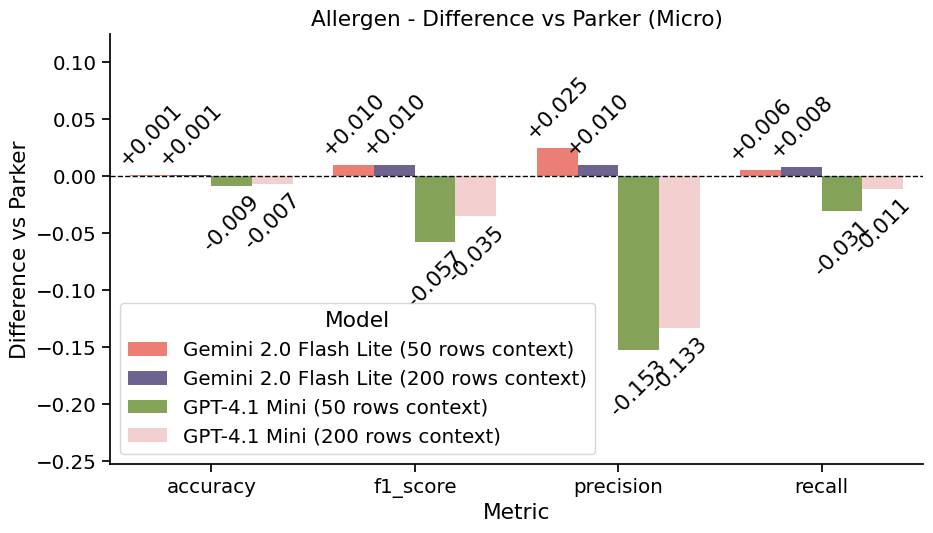

Allergen - Difference vs Parker (Column)
|     | Model                                    | Column         | Metric    |   Difference |
|-----|------------------------------------------|----------------|-----------|--------------|
|   0 | Gemini 2.0 Flash Lite (50 rows context)  | code           | precision |        0.000 |
|   1 | Gemini 2.0 Flash Lite (50 rows context)  | code           | recall    |        0.000 |
|   2 | Gemini 2.0 Flash Lite (50 rows context)  | nuts           | precision |       -0.012 |
|   3 | Gemini 2.0 Flash Lite (50 rows context)  | nuts           | recall    |       -0.049 |
|   4 | Gemini 2.0 Flash Lite (50 rows context)  | almondnuts     | precision |        0.000 |
|   5 | Gemini 2.0 Flash Lite (50 rows context)  | almondnuts     | recall    |        0.000 |
|   6 | Gemini 2.0 Flash Lite (50 rows context)  | brazil_nuts    | precision |        0.000 |
|   7 | Gemini 2.0 Flash Lite (50 rows context)  | brazil_nuts    | recall    |        0.000 |
|   8 | G

/tmp/ipykernel_64683/2777122064.py:234: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(column_names, rotation=90, ha='right', fontsize=14)


In [ ]:
# Allergen paths and files
base_path = os.path.join('.', 'allergen')
micro_files = {
    "Parker": "parker_results_micro.json",
    # "Gemini 2.0 Flash Lite (0 rows context)": "gemini_2_0_flash_lite_0_rows_context_results_micro.json",
    "Gemini 2.0 Flash Lite (50 rows context)": "gemini_2_0_flash_lite_50_rows_context_results_micro.json",
    "Gemini 2.0 Flash Lite (200 rows context)": "gemini_2_0_flash_lite_200_rows_context_results_micro.json",
    # "GPT-4.1 Mini (0 rows context)": "gpt_4_1_mini_2025_04_14_0_rows_context_results_micro.json",
    "GPT-4.1 Mini (50 rows context)": "gpt_4_1_mini_2025_04_14_50_rows_context_results_micro.json",
    "GPT-4.1 Mini (200 rows context)": "gpt_4_1_mini_2025_04_14_200_rows_context_results_micro.json",
}
macro_files = {
    "Parker": "parker_results_macro.json",
    # "Gemini 2.0 Flash Lite (0 rows context)": "gemini_2_0_flash_lite_0_rows_context_results_macro.json",
    "Gemini 2.0 Flash Lite (50 rows context)": "gemini_2_0_flash_lite_50_rows_context_results_macro.json",
    "Gemini 2.0 Flash Lite (200 rows context)": "gemini_2_0_flash_lite_200_rows_context_results_macro.json",
    # "GPT-4.1 Mini (0 rows context)": "gpt_4_1_mini_2025_04_14_0_rows_context_results_macro.json",
    "GPT-4.1 Mini (50 rows context)": "gpt_4_1_mini_2025_04_14_50_rows_context_results_macro.json",
    "GPT-4.1 Mini (200 rows context)": "gpt_4_1_mini_2025_04_14_200_rows_context_results_macro.json",
}
# Micro
model_data = load_model_data(base_path, micro_files)
title = "Allergen - Micro Analysis: Model Comparison by Metric"
print(title)
plot_micro_analysis(model_data, title=title)
# Macro
model_data = load_model_data(base_path, macro_files)
title = "Allergen - Macro Analysis: Model Comparison by Metric"
print(title)
plot_macro_analysis(model_data, title=title)

title = "Allergen - Column Analysis: Model Comparison by Metric"
print(title)
plot_column_analysis(model_data, title=title)
# Difference vs Parker (Micro)
title = "Allergen - Difference vs Parker (Micro)"
print(title)
plot_difference_vs_parker(load_model_data(base_path, micro_files), title=title)
# Difference vs Parker (Macro)
title = "Allergen - Difference vs Parker (Column)"
print(title)
plot_column_difference_vs_parker(load_model_data(base_path, macro_files), title=title)

Allergen - F1 Score
|    | Model                                    |   F1 Score |
|----|------------------------------------------|------------|
|  0 | Parker                                   |      0.438 |
|  1 | Gemini 2.0 Flash Lite (50 rows context)  |      0.448 |
|  2 | Gemini 2.0 Flash Lite (200 rows context) |      0.448 |
|  3 | GPT-4.1 Mini (50 rows context)           |      0.381 |
|  4 | GPT-4.1 Mini (200 rows context)          |      0.403 |


/tmp/ipykernel_49848/2777122064.py:252: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


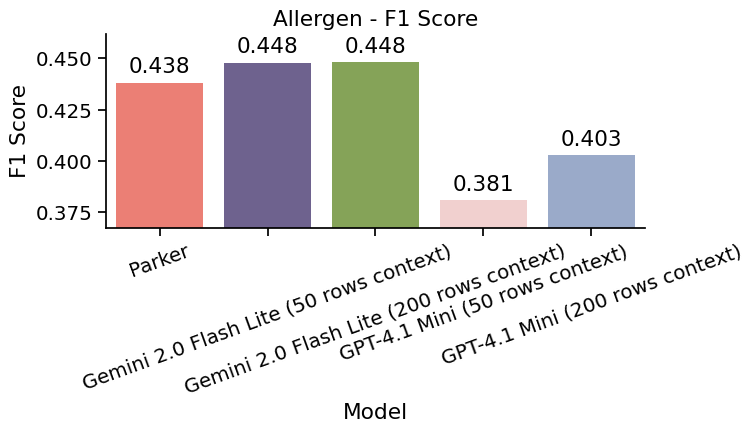

In [ ]:
# F1 Score Only - Allergen
model_data = load_model_data(base_path, micro_files)
title = "Allergen - F1 Score"
print(title)
plot_f1_score_only(model_data, title=title)


# Allergen (Different Options)

Allergen (Different Options) - Micro Analysis: Model Comparison by Metric
|    | Model                                                     | Metric    |   Score |
|----|-----------------------------------------------------------|-----------|---------|
|  0 | Parker                                                    | accuracy  |   0.938 |
|  1 | Parker                                                    | f1_score  |   0.438 |
|  2 | Parker                                                    | precision |   0.764 |
|  3 | Parker                                                    | recall    |   0.307 |
|  4 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | accuracy  |   0.939 |
|  5 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | f1_score  |   0.448 |
|  6 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | precision |   0.789 |
|  7 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | recall    |   0.313 |
|  8 | Gemini 2.0 Flash Lite (50 row

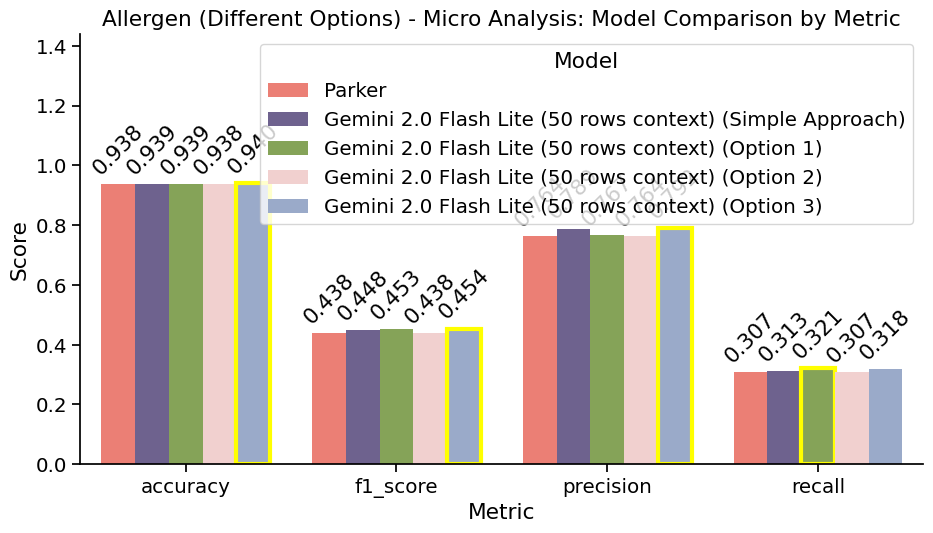

Allergen (Different Options) - Macro Analysis: Model Comparison by Metric
|    | Model                                                     | Metric    |   Score |
|----|-----------------------------------------------------------|-----------|---------|
|  0 | Parker                                                    | accuracy  |   0.938 |
|  1 | Parker                                                    | f1_score  |   0.281 |
|  2 | Parker                                                    | precision |   0.424 |
|  3 | Parker                                                    | recall    |   0.237 |
|  4 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | accuracy  |   0.939 |
|  5 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | f1_score  |   0.288 |
|  6 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | precision |   0.432 |
|  7 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | recall    |   0.242 |
|  8 | Gemini 2.0 Flash Lite (50 row

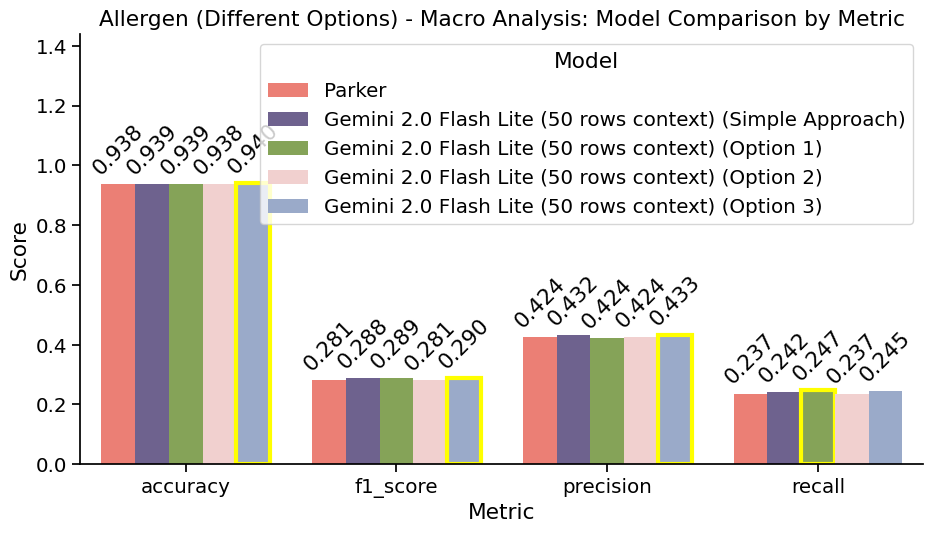

Allergen (Different Options) - Column Analysis: Model Comparison by Metric
|     | Model                                                     | Column         | Metric    |   Score |
|-----|-----------------------------------------------------------|----------------|-----------|---------|
|   0 | Parker                                                    | code           | precision |   0.000 |
|   1 | Parker                                                    | code           | recall    |   0.000 |
|   2 | Parker                                                    | nuts           | precision |   0.852 |
|   3 | Parker                                                    | nuts           | recall    |   0.561 |
|   4 | Parker                                                    | almondnuts     | precision |   1.000 |
|   5 | Parker                                                    | almondnuts     | recall    |   0.012 |
|   6 | Parker                                                    | b

/tmp/ipykernel_49848/2777122064.py:139: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(column_names, rotation=90, ha='right', fontsize=14)


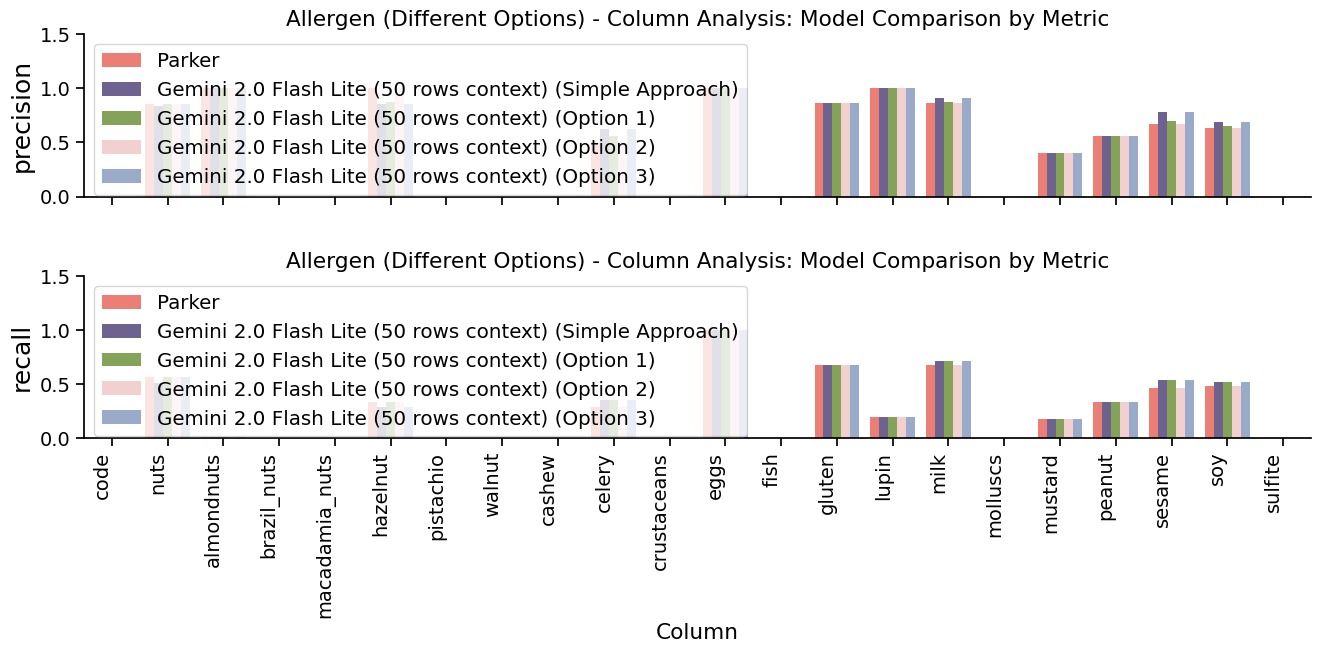

Allergen (Different Options) - Difference vs Parker (Micro)
|    | Model                                                     | Metric    |   Difference |
|----|-----------------------------------------------------------|-----------|--------------|
|  0 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | accuracy  |        0.001 |
|  1 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | f1_score  |        0.010 |
|  2 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | precision |        0.025 |
|  3 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | recall    |        0.006 |
|  4 | Gemini 2.0 Flash Lite (50 rows context) (Option 1)        | accuracy  |        0.001 |
|  5 | Gemini 2.0 Flash Lite (50 rows context) (Option 1)        | f1_score  |        0.015 |
|  6 | Gemini 2.0 Flash Lite (50 rows context) (Option 1)        | precision |        0.003 |
|  7 | Gemini 2.0 Flash Lite (50 rows context) (Option 1)        | recall    |        0.014 |


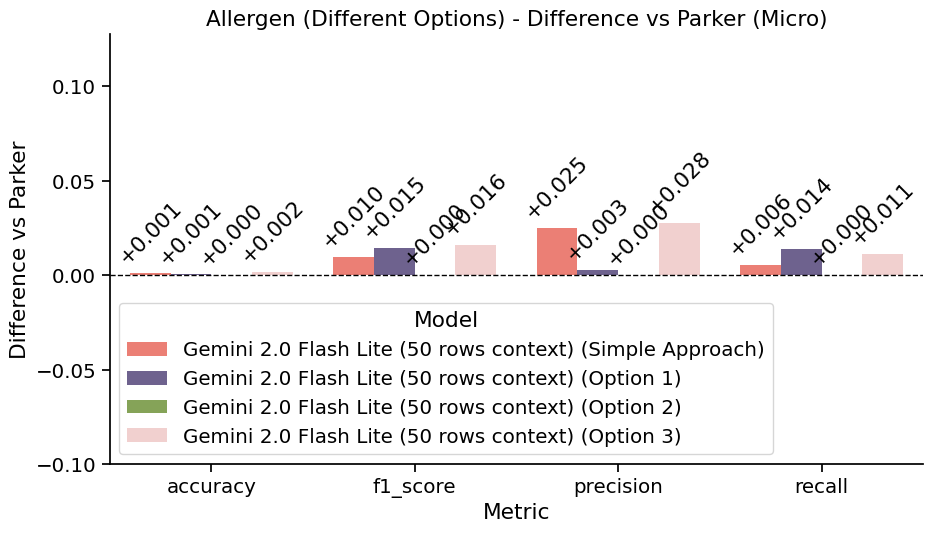

Allergen (Different Options) - Difference vs Parker (Column)
|     | Model                                                     | Column         | Metric    |   Difference |
|-----|-----------------------------------------------------------|----------------|-----------|--------------|
|   0 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | code           | precision |        0.000 |
|   1 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | code           | recall    |        0.000 |
|   2 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | nuts           | precision |       -0.012 |
|   3 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | nuts           | recall    |       -0.049 |
|   4 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | almondnuts     | precision |        0.000 |
|   5 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) | almondnuts     | recall    |        0.000 |
|   6 | Gemini 2.0 Flash Lite (50 rows cont

/tmp/ipykernel_49848/2777122064.py:234: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(column_names, rotation=90, ha='right', fontsize=14)


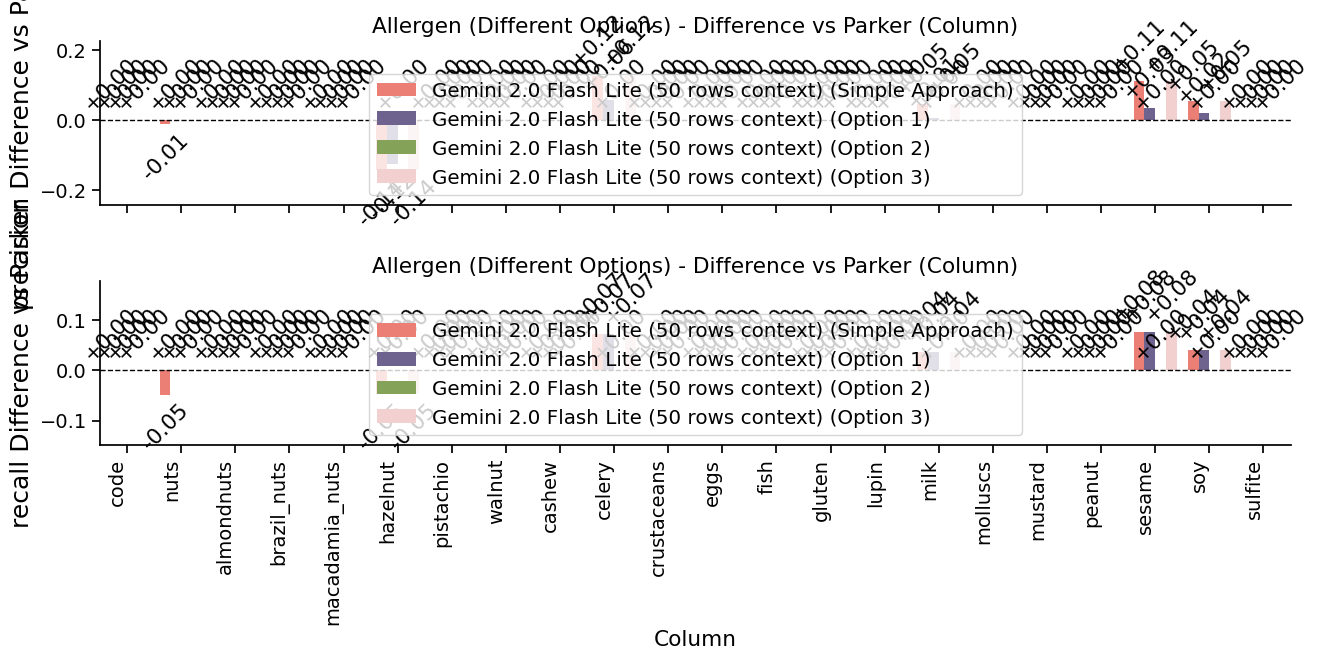

In [ ]:
# Allergen paths and files
base_path = os.path.join('.', 'allergen')
micro_files = {
    "Parker": "parker_results_micro.json",
    "Gemini 2.0 Flash Lite (50 rows context) (Simple Approach)": "gemini_2_0_flash_lite_50_rows_context_results_micro.json",
    "Gemini 2.0 Flash Lite (50 rows context) (Option 1)": "gemini_2_0_flash_lite_50_rows_context_option_1_results_micro.json",
    "Gemini 2.0 Flash Lite (50 rows context) (Option 2)": "gemini_2_0_flash_lite_50_rows_context_option_2_results_micro.json",
    "Gemini 2.0 Flash Lite (50 rows context) (Option 3)": "gemini_2_0_flash_lite_50_rows_context_option_3_results_micro.json",
}
macro_files = {
    "Parker": "parker_results_macro.json",
    "Gemini 2.0 Flash Lite (50 rows context) (Simple Approach)": "gemini_2_0_flash_lite_50_rows_context_results_macro.json",
    "Gemini 2.0 Flash Lite (50 rows context) (Option 1)": "gemini_2_0_flash_lite_50_rows_context_option_1_results_macro.json",
    "Gemini 2.0 Flash Lite (50 rows context) (Option 2)": "gemini_2_0_flash_lite_50_rows_context_option_2_results_macro.json",
    "Gemini 2.0 Flash Lite (50 rows context) (Option 3)": "gemini_2_0_flash_lite_50_rows_context_option_3_results_macro.json",
}
# Micro
model_data = load_model_data(base_path, micro_files)
title = "Allergen (Different Options) - Micro Analysis: Model Comparison by Metric"
print(title)
plot_micro_analysis(model_data, title=title)
# Macro
model_data = load_model_data(base_path, macro_files)
title = "Allergen (Different Options) - Macro Analysis: Model Comparison by Metric"
print(title)
plot_macro_analysis(model_data, title=title)

title = "Allergen (Different Options) - Column Analysis: Model Comparison by Metric"
print(title)
plot_column_analysis(model_data, title=title)
# Difference vs Parker (Micro)
title = "Allergen (Different Options) - Difference vs Parker (Micro)"
print(title)
plot_difference_vs_parker(load_model_data(base_path, micro_files), title=title)
# Difference vs Parker (Macro)
title = "Allergen (Different Options) - Difference vs Parker (Column)"
print(title)
plot_column_difference_vs_parker(load_model_data(base_path, macro_files), title=title)

Allergen (Different Options) - F1 Score
|    | Model                                                     |   F1 Score |
|----|-----------------------------------------------------------|------------|
|  0 | Parker                                                    |      0.438 |
|  1 | Gemini 2.0 Flash Lite (50 rows context) (Simple Approach) |      0.448 |
|  2 | Gemini 2.0 Flash Lite (50 rows context) (Option 1)        |      0.453 |
|  3 | Gemini 2.0 Flash Lite (50 rows context) (Option 2)        |      0.438 |
|  4 | Gemini 2.0 Flash Lite (50 rows context) (Option 3)        |      0.454 |


/tmp/ipykernel_49848/2777122064.py:252: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


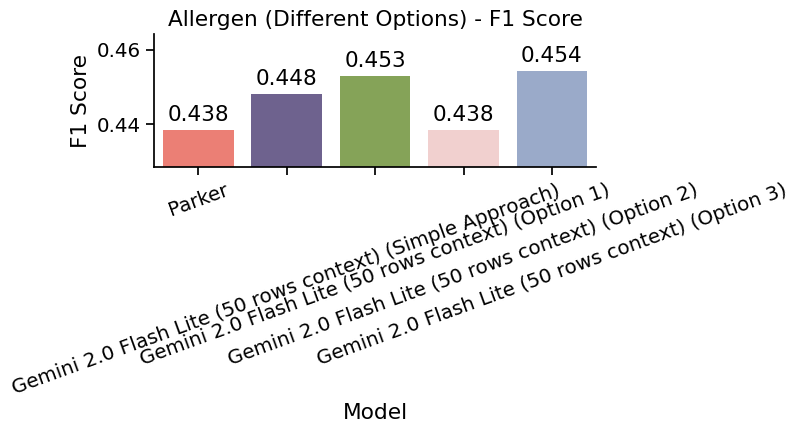

In [ ]:
# F1 Score Only - Allergen (Different Options)
model_data = load_model_data(base_path, micro_files)
title = "Allergen (Different Options) - F1 Score"
print(title)
plot_f1_score_only(model_data, title=title)


# Flight Dataset

Flight - Micro Analysis: Model Comparison by Metric
|    | Model                 | Metric    |   Score |
|----|-----------------------|-----------|---------|
|  0 | Parker                | accuracy  |   0.373 |
|  1 | Parker                | f1_score  |   0.222 |
|  2 | Parker                | precision |   0.213 |
|  3 | Parker                | recall    |   0.232 |
|  4 | Gemini 2.0 Flash Lite | accuracy  |   0.749 |
|  5 | Gemini 2.0 Flash Lite | f1_score  |   0.640 |
|  6 | Gemini 2.0 Flash Lite | precision |   0.717 |
|  7 | Gemini 2.0 Flash Lite | recall    |   0.578 |


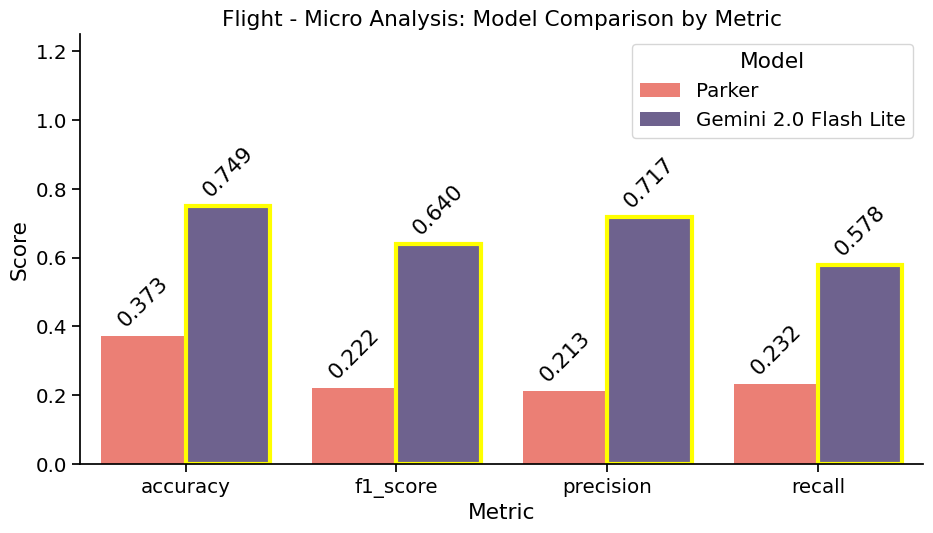

Flight - Macro Analysis: Model Comparison by Metric
|    | Model                 | Metric    |   Score |
|----|-----------------------|-----------|---------|
|  0 | Parker                | accuracy  |   0.373 |
|  1 | Parker                | f1_score  |   0.174 |
|  2 | Parker                | precision |   0.173 |
|  3 | Parker                | recall    |   0.175 |
|  4 | Gemini 2.0 Flash Lite | accuracy  |   0.749 |
|  5 | Gemini 2.0 Flash Lite | f1_score  |   0.543 |
|  6 | Gemini 2.0 Flash Lite | precision |   0.564 |
|  7 | Gemini 2.0 Flash Lite | recall    |   0.527 |


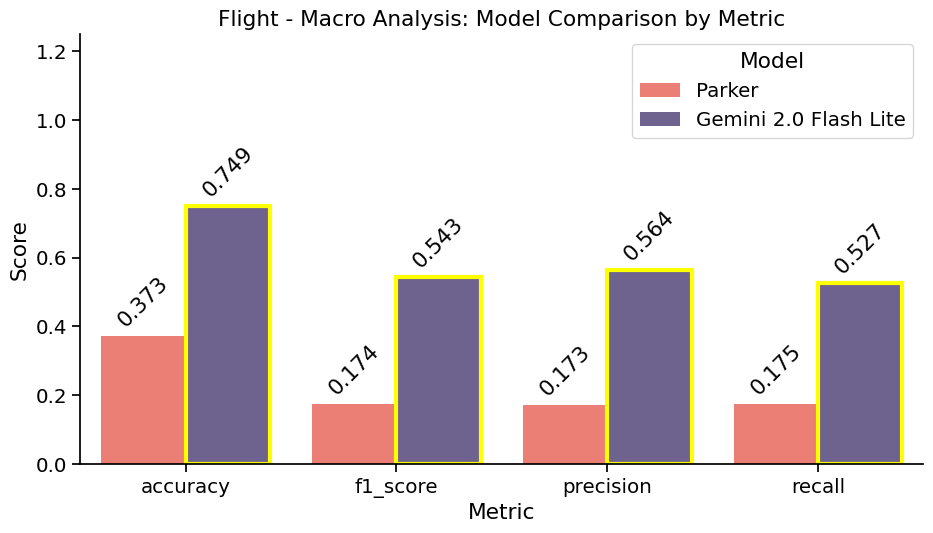

Flight - Column Analysis: Model Comparison by Metric
|    | Model                 | Column              | Metric    |   Score |
|----|-----------------------|---------------------|-----------|---------|
|  0 | Parker                | composed_key        | precision |   0.000 |
|  1 | Parker                | composed_key        | recall    |   0.000 |
|  2 | Parker                | actual_arrival      | precision |   0.866 |
|  3 | Parker                | actual_arrival      | recall    |   0.874 |
|  4 | Parker                | actual_departure    | precision |   0.000 |
|  5 | Parker                | actual_departure    | recall    |   0.000 |
|  6 | Parker                | scheduled_arrival   | precision |   0.000 |
|  7 | Parker                | scheduled_arrival   | recall    |   0.000 |
|  8 | Parker                | scheduled_departure | precision |   0.000 |
|  9 | Parker                | scheduled_departure | recall    |   0.000 |
| 10 | Gemini 2.0 Flash Lite | composed_key    

/tmp/ipykernel_49848/2777122064.py:139: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(column_names, rotation=90, ha='right', fontsize=14)


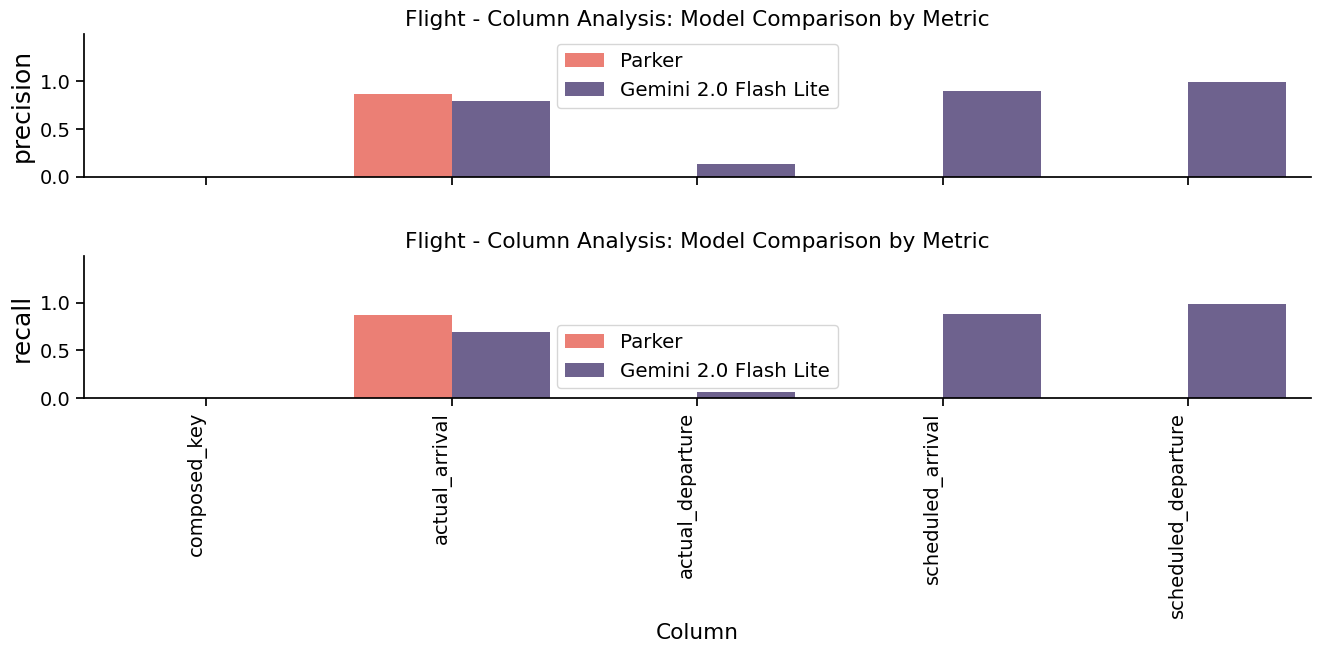

Flight - Difference vs Parker (Micro)
|    | Model                 | Metric    |   Difference |
|----|-----------------------|-----------|--------------|
|  0 | Gemini 2.0 Flash Lite | accuracy  |        0.376 |
|  1 | Gemini 2.0 Flash Lite | f1_score  |        0.418 |
|  2 | Gemini 2.0 Flash Lite | precision |        0.504 |
|  3 | Gemini 2.0 Flash Lite | recall    |        0.346 |


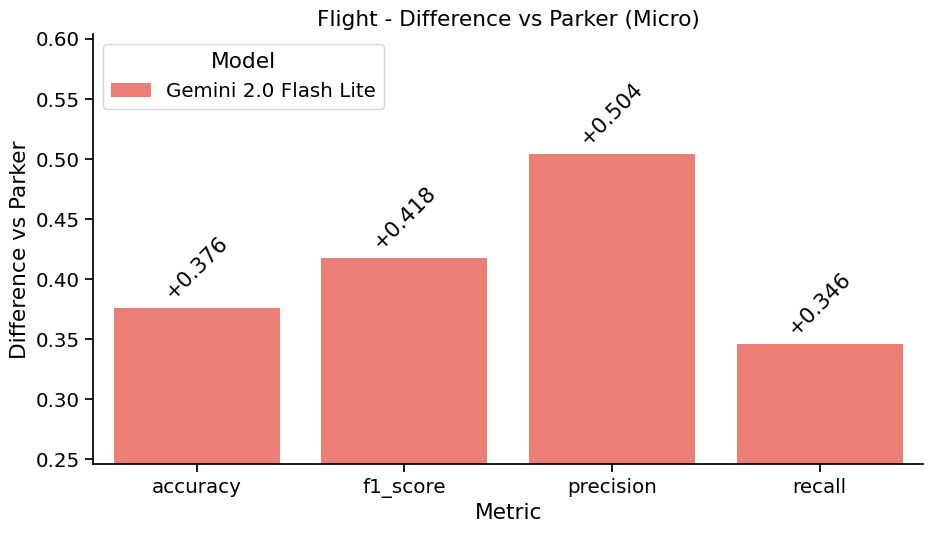

Flight - Difference vs Parker (Column)
|    | Model                 | Column              | Metric    |   Difference |
|----|-----------------------|---------------------|-----------|--------------|
|  0 | Gemini 2.0 Flash Lite | composed_key        | precision |        0.000 |
|  1 | Gemini 2.0 Flash Lite | composed_key        | recall    |        0.000 |
|  2 | Gemini 2.0 Flash Lite | actual_arrival      | precision |       -0.074 |
|  3 | Gemini 2.0 Flash Lite | actual_arrival      | recall    |       -0.177 |
|  4 | Gemini 2.0 Flash Lite | actual_departure    | precision |        0.130 |
|  5 | Gemini 2.0 Flash Lite | actual_departure    | recall    |        0.070 |
|  6 | Gemini 2.0 Flash Lite | scheduled_arrival   | precision |        0.899 |
|  7 | Gemini 2.0 Flash Lite | scheduled_arrival   | recall    |        0.880 |
|  8 | Gemini 2.0 Flash Lite | scheduled_departure | precision |        0.997 |
|  9 | Gemini 2.0 Flash Lite | scheduled_departure | recall    |        0.989 |


/tmp/ipykernel_49848/2777122064.py:234: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(column_names, rotation=90, ha='right', fontsize=14)


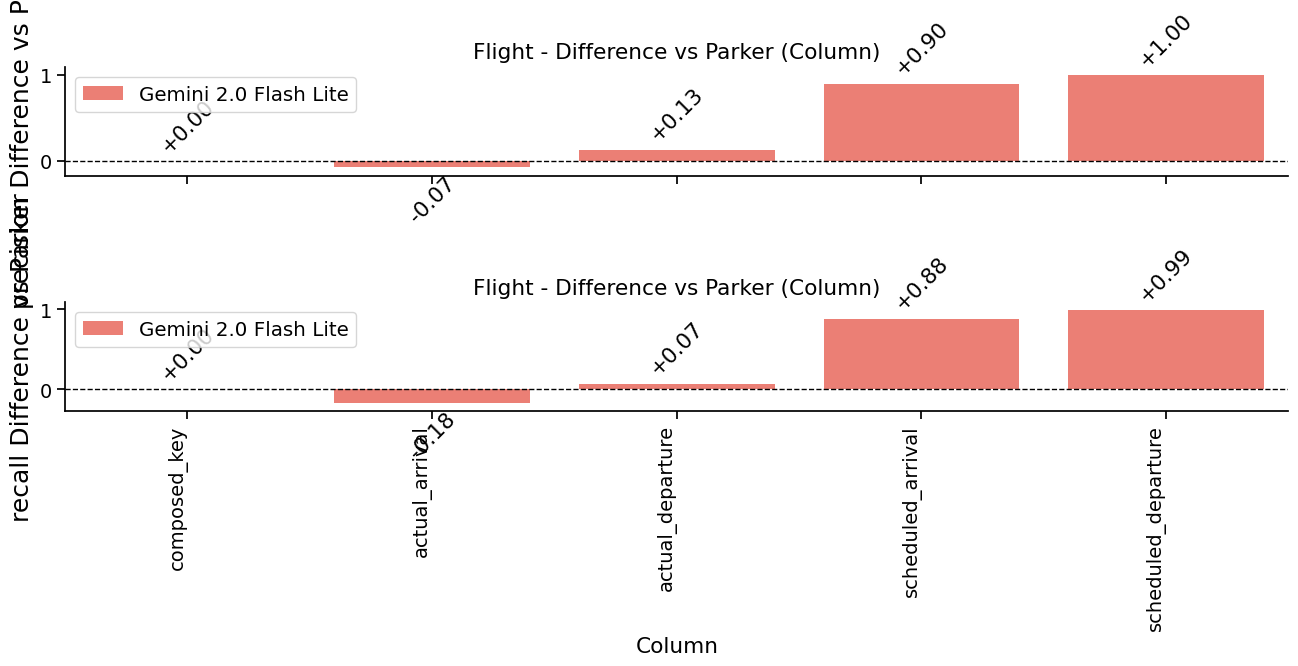

In [ ]:
# Flight paths and files
base_path = os.path.join('.','flight')
micro_files = {
    "Parker": 'parker_results_micro.json',
    "Gemini 2.0 Flash Lite": 'gemini_2_0_flash_lite_results_micro.json',
}
macro_files = {
    "Parker": 'parker_results_macro.json',
    "Gemini 2.0 Flash Lite": 'gemini_2_0_flash_lite_results_macro.json',
}
# Micro
model_data = load_model_data(base_path, micro_files)
title = "Flight - Micro Analysis: Model Comparison by Metric"
print(title)
plot_micro_analysis(model_data, title=title)
# Macro

model_data = load_model_data(base_path, macro_files)

title = "Flight - Macro Analysis: Model Comparison by Metric"
print(title)
plot_macro_analysis(model_data, title=title)

title = "Flight - Column Analysis: Model Comparison by Metric"
print(title)
plot_column_analysis(model_data, title=title)

# Difference vs Parker (Micro)
title = "Flight - Difference vs Parker (Micro)"
print(title)
plot_difference_vs_parker(load_model_data(base_path, micro_files), title=title)
# Difference vs Parker (Macro)
title = "Flight - Difference vs Parker (Column)"
print(title)
plot_column_difference_vs_parker(load_model_data(base_path, macro_files), title=title)

Flight - F1 Score
|    | Model                 |   F1 Score |
|----|-----------------------|------------|
|  0 | Parker                |      0.222 |
|  1 | Gemini 2.0 Flash Lite |      0.640 |


/tmp/ipykernel_49848/2777122064.py:252: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


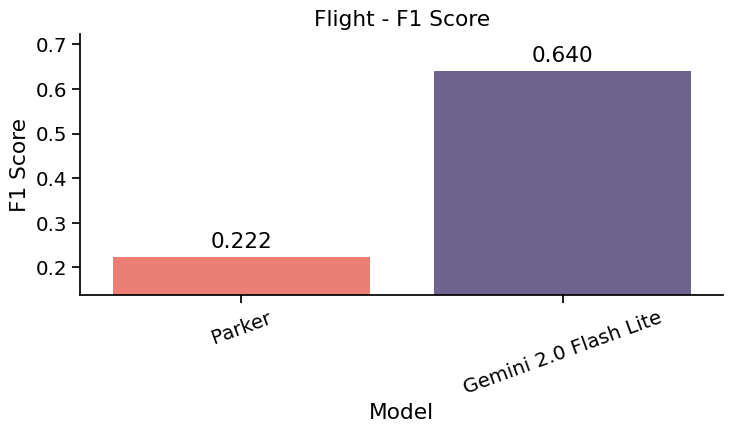

In [ ]:
# F1 Score Only - Flight
model_data = load_model_data(base_path, micro_files)
title = "Flight - F1 Score"
print(title)
plot_f1_score_only(model_data, title=title)


# Radiology Dataset

Radiology - Micro Analysis: Model Comparison by Metric
|    | Model                                  | Metric    |   Score |
|----|----------------------------------------|-----------|---------|
|  0 | Gemini 2.0 Flash Lite 2 copies 0 rows  | accuracy  |   0.984 |
|  1 | Gemini 2.0 Flash Lite 2 copies 0 rows  | f1_score  |   0.927 |
|  2 | Gemini 2.0 Flash Lite 2 copies 0 rows  | precision |   1.000 |
|  3 | Gemini 2.0 Flash Lite 2 copies 0 rows  | recall    |   0.863 |
|  4 | Gemini 2.0 Flash Lite 2 copies 50 rows | accuracy  |   0.998 |
|  5 | Gemini 2.0 Flash Lite 2 copies 50 rows | f1_score  |   0.992 |
|  6 | Gemini 2.0 Flash Lite 2 copies 50 rows | precision |   1.000 |
|  7 | Gemini 2.0 Flash Lite 2 copies 50 rows | recall    |   0.983 |
|  8 | Gemini 2.0 Flash Lite 5 copies 0 rows  | accuracy  |   1.000 |
|  9 | Gemini 2.0 Flash Lite 5 copies 0 rows  | f1_score  |   1.000 |
| 10 | Gemini 2.0 Flash Lite 5 copies 0 rows  | precision |   1.000 |
| 11 | Gemini 2.0 Flash Lite 5 copi

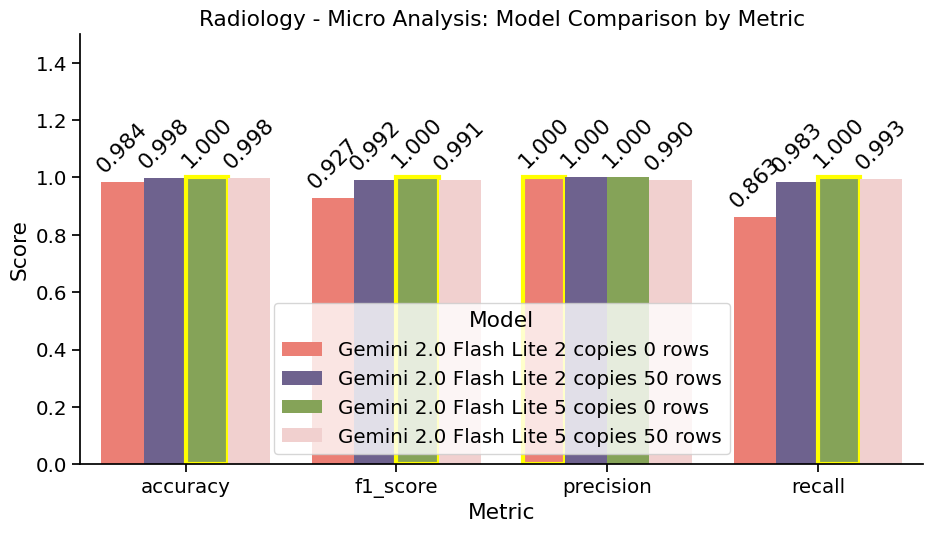

Radiology - Macro Analysis: Model Comparison by Metric
|    | Model                                  | Metric    |   Score |
|----|----------------------------------------|-----------|---------|
|  0 | Gemini 2.0 Flash Lite 2 copies 0 rows  | accuracy  |   0.984 |
|  1 | Gemini 2.0 Flash Lite 2 copies 0 rows  | f1_score  |   0.744 |
|  2 | Gemini 2.0 Flash Lite 2 copies 0 rows  | precision |   0.800 |
|  3 | Gemini 2.0 Flash Lite 2 copies 0 rows  | recall    |   0.699 |
|  4 | Gemini 2.0 Flash Lite 2 copies 50 rows | accuracy  |   0.998 |
|  5 | Gemini 2.0 Flash Lite 2 copies 50 rows | f1_score  |   0.795 |
|  6 | Gemini 2.0 Flash Lite 2 copies 50 rows | precision |   0.800 |
|  7 | Gemini 2.0 Flash Lite 2 copies 50 rows | recall    |   0.790 |
|  8 | Gemini 2.0 Flash Lite 5 copies 0 rows  | accuracy  |   1.000 |
|  9 | Gemini 2.0 Flash Lite 5 copies 0 rows  | f1_score  |   0.800 |
| 10 | Gemini 2.0 Flash Lite 5 copies 0 rows  | precision |   0.800 |
| 11 | Gemini 2.0 Flash Lite 5 copi

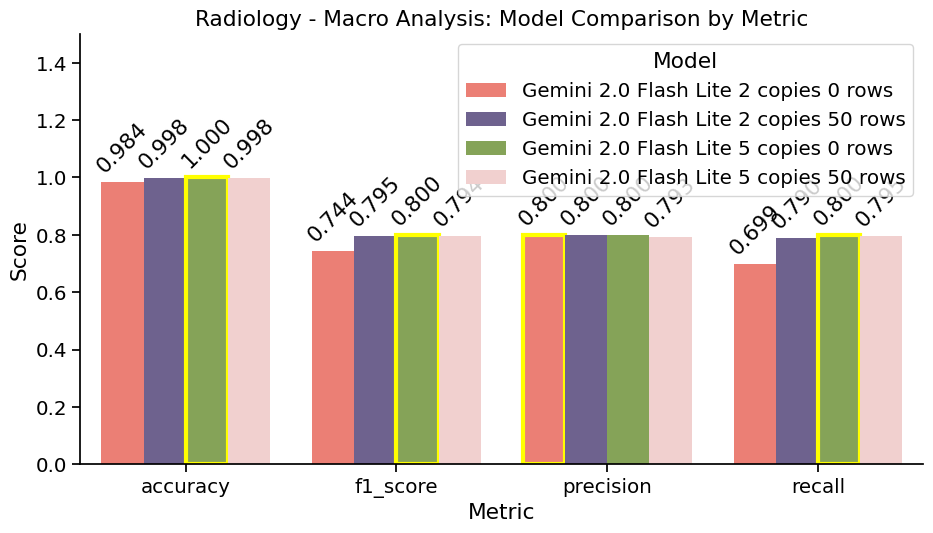

Radiology - Column Analysis: Model Comparison by Metric
|    | Model                                  | Column      | Metric    |   Score |
|----|----------------------------------------|-------------|-----------|---------|
|  0 | Gemini 2.0 Flash Lite 2 copies 0 rows  | dicom_uid   | precision |   0.000 |
|  1 | Gemini 2.0 Flash Lite 2 copies 0 rows  | dicom_uid   | recall    |   0.000 |
|  2 | Gemini 2.0 Flash Lite 2 copies 0 rows  | rows        | precision |   1.000 |
|  3 | Gemini 2.0 Flash Lite 2 copies 0 rows  | rows        | recall    |   1.000 |
|  4 | Gemini 2.0 Flash Lite 2 copies 0 rows  | columns     | precision |   1.000 |
|  5 | Gemini 2.0 Flash Lite 2 copies 0 rows  | columns     | recall    |   0.786 |
|  6 | Gemini 2.0 Flash Lite 2 copies 0 rows  | series_desc | precision |   1.000 |
|  7 | Gemini 2.0 Flash Lite 2 copies 0 rows  | series_desc | recall    |   0.818 |
|  8 | Gemini 2.0 Flash Lite 2 copies 0 rows  | modality    | precision |   1.000 |
|  9 | Gemini 2.0 Fl

/tmp/ipykernel_49848/2777122064.py:139: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(column_names, rotation=90, ha='right', fontsize=14)


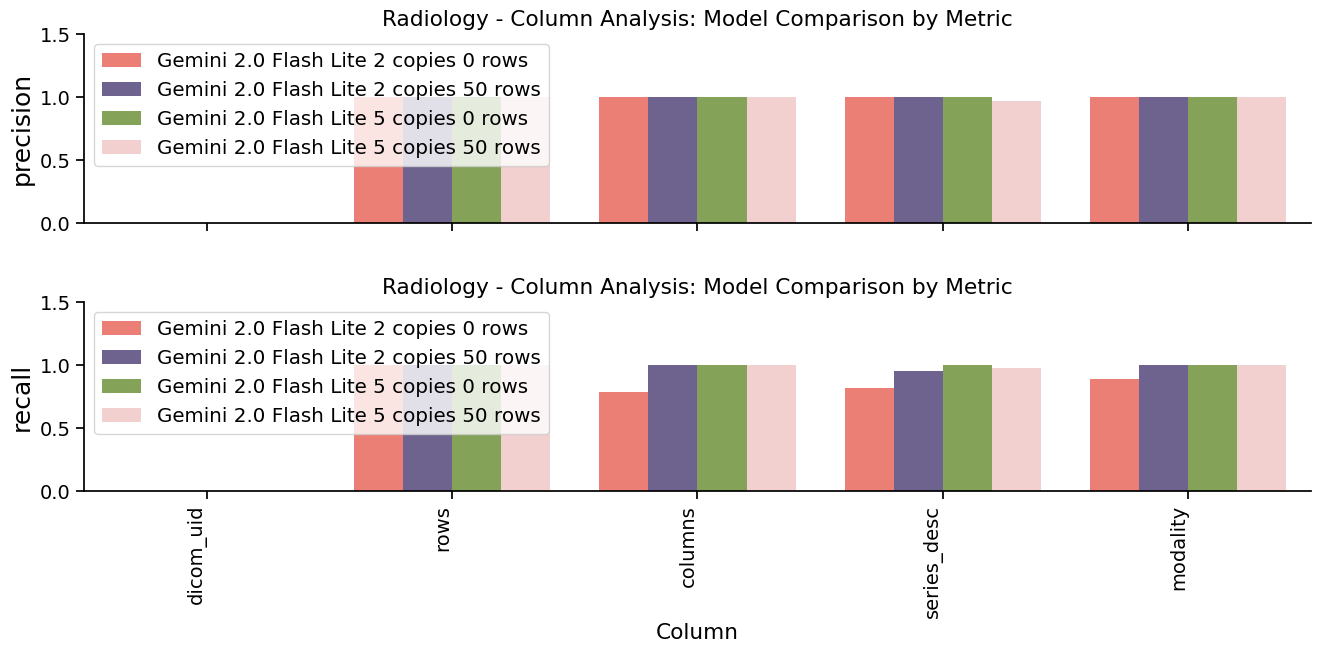

Radiology - Difference vs Parker (Micro)
Baseline 'Parker' not found in model_data.
Radiology - Difference vs Parker (Column)
Baseline 'Parker' not found in model_data.


In [ ]:
# Radiology paths and files
base_path = os.path.join('.', 'radiology_self_generated')
micro_files = {
    "Gemini 2.0 Flash Lite 2 copies 0 rows": "gemini_2_0_flash_lite_2_copies_0_rows_context_results_micro.json",
    "Gemini 2.0 Flash Lite 2 copies 50 rows": "gemini_2_0_flash_lite_2_copies_50_rows_context_results_micro.json",
    "Gemini 2.0 Flash Lite 5 copies 0 rows": "gemini_2_0_flash_lite_5_copies_0_rows_context_results_micro.json",
    "Gemini 2.0 Flash Lite 5 copies 50 rows": "gemini_2_0_flash_lite_5_copies_50_rows_context_results_micro.json",
    "GPT-4.1 Mini 5 copies 0 rows": "gpt_4_1_mini_2025_04_14_5_copies_0_rows_context_results_micro.json",
    "GPT-4.1 Mini 5 copies 50 rows": "gpt_4_1_mini_2025_04_14_5_copies_50_rows_context_results_micro_1.json",
    "GPT-4.1 Mini 5 copies 100 rows": "gpt_4_1_mini_2025_04_14_5_copies_100_rows_context_results_micro.json",
}
macro_files = {
    "Gemini 2.0 Flash Lite 2 copies 0 rows": "gemini_2_0_flash_lite_2_copies_0_rows_context_results_macro.json",
    "Gemini 2.0 Flash Lite 2 copies 50 rows": "gemini_2_0_flash_lite_2_copies_50_rows_context_results_macro.json",
    "Gemini 2.0 Flash Lite 5 copies 0 rows": "gemini_2_0_flash_lite_5_copies_0_rows_context_results_macro.json",
    "Gemini 2.0 Flash Lite 5 copies 50 rows": "gemini_2_0_flash_lite_5_copies_50_rows_context_results_macro.json",
    "GPT-4.1 Mini 5 copies 0 rows": "gpt_4_1_mini_2025_04_14_5_copies_0_rows_context_results_macro.json",
    "GPT-4.1 Mini 5 copies 50 rows": "gpt_4_1_mini_2025_04_14_5_copies_50_rows_context_results_macro_1.json",
    "GPT-4.1 Mini 5 copies 100 rows": "gpt_4_1_mini_2025_04_14_5_copies_100_rows_context_results_macro.json",
}
# Micro
model_data = load_model_data(base_path, micro_files)
title = "Radiology - Micro Analysis: Model Comparison by Metric"
print(title)
plot_micro_analysis(model_data, title=title)
# Macro
model_data = load_model_data(base_path, macro_files)
title = "Radiology - Macro Analysis: Model Comparison by Metric"
print(title)
plot_macro_analysis(model_data, title=title)

title = "Radiology - Column Analysis: Model Comparison by Metric"
print(title)
plot_column_analysis(model_data, title=title)
# Difference vs Parker (Micro)
title = "Radiology - Difference vs Parker (Micro)"
print(title)
plot_difference_vs_parker(load_model_data(base_path, micro_files), title=title)
# Difference vs Parker (Macro)
title = "Radiology - Difference vs Parker (Column)"
print(title)
plot_column_difference_vs_parker(load_model_data(base_path, macro_files), title=title)

Radiology - F1 Score
|    | Model                                  |   F1 Score |
|----|----------------------------------------|------------|
|  0 | Gemini 2.0 Flash Lite 2 copies 0 rows  |      0.927 |
|  1 | Gemini 2.0 Flash Lite 2 copies 50 rows |      0.992 |
|  2 | Gemini 2.0 Flash Lite 5 copies 0 rows  |      1.000 |
|  3 | Gemini 2.0 Flash Lite 5 copies 50 rows |      0.991 |


/tmp/ipykernel_49848/2777122064.py:252: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


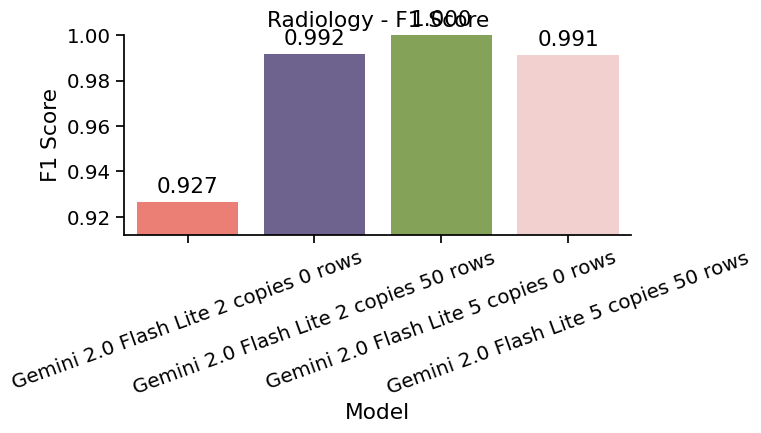

In [ ]:
# F1 Score Only - Radiology
model_data = load_model_data(base_path, micro_files)
title = "Radiology - F1 Score"
print(title)
plot_f1_score_only(model_data, title=title)